In [66]:
# Importações
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from prophet import Prophet
from tqdm import tqdm

In [12]:
# Leitura do arquivo
df = pd.read_csv("agg_inad_consolidado.csv")

In [18]:
# Visualizar os tipos das colunas
df.dtypes

data_base                               datetime64[ns]
uf                                              object
cliente                                         object
ocupacao                                        object
cnae_secao                                      object
porte                                           object
modalidade                                      object
soma_a_vencer_ate_90_dias                      float64
soma_numero_de_operacoes                       float64
soma_carteira_ativa                            float64
soma_carteira_inadimplida_arrastada            float64
soma_ativo_problematico                        float64
media_a_vencer_ate_90_dias                     float64
media_numero_de_operacoes                      float64
media_carteira_ativa                           float64
media_carteira_inadimplida_arrastada           float64
media_ativo_problematico                       float64
min_a_vencer_ate_90_dias                       float64
min_numero

In [6]:
# Ajustar nome da coluna de data e valor
df["data_base"] = pd.to_datetime(df["data_base"])
df = df.sort_values("data_base")

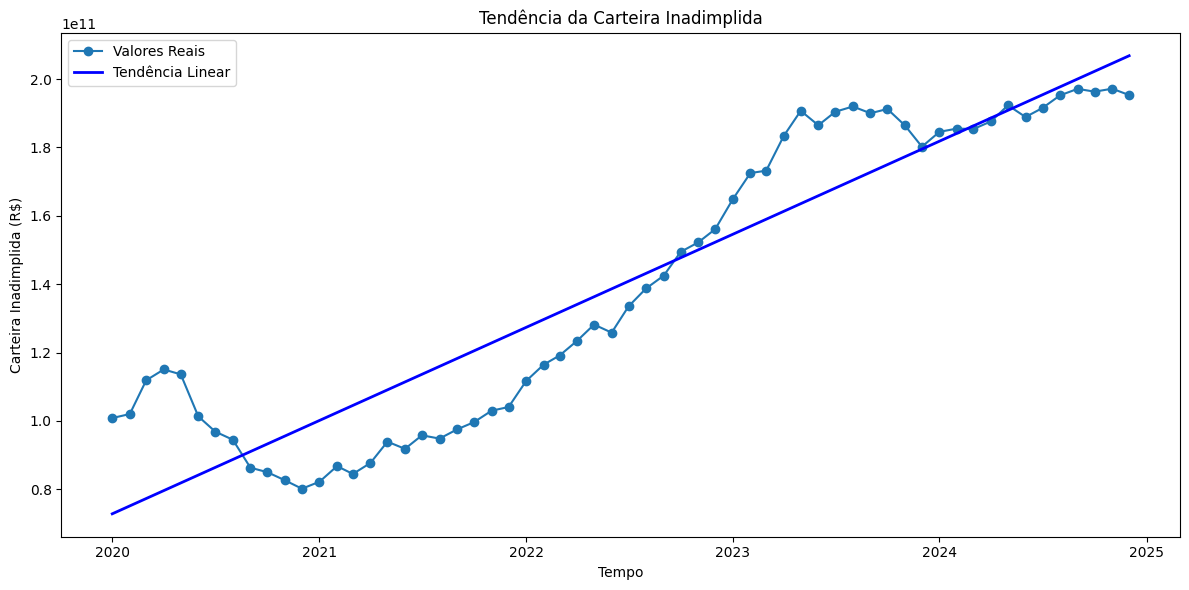

In [10]:
# Agregar por mês (caso tenha dados diários ou múltiplos registros por mês)
df_mes = df.groupby(df["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mes["data_base"] = pd.to_datetime(df_mes["data_base"].astype(str))

# Transformar data em valor numérico (ordinal)
df_mes["mes_ordinal"] = df_mes["data_base"].map(lambda x: x.toordinal())

# Variáveis para o modelo
X = df_mes["mes_ordinal"].values.reshape(-1, 1)
y = df_mes["soma_carteira_inadimplida_arrastada"].values

# Criar e ajustar o modelo de tendência
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# Plotar os dados com a tendência
plt.figure(figsize=(12, 6))
plt.plot(df_mes["data_base"], y, label="Valores Reais", marker='o')
plt.plot(df_mes["data_base"], y_pred, label="Tendência Linear", color='blue', linewidth=2)
plt.title("Tendência da Carteira Inadimplida")
plt.xlabel("Tempo")
plt.ylabel("Carteira Inadimplida (R$)")
plt.legend()
plt.tight_layout()
plt.show()

In [13]:
# ---- MÉTRICAS DE AVALIAÇÃO ----
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"Métricas do Modelo de Tendência:")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.2f} R$")

Métricas do Modelo de Tendência:
R²: 0.8568
RMSE: 16078073267.71 R$


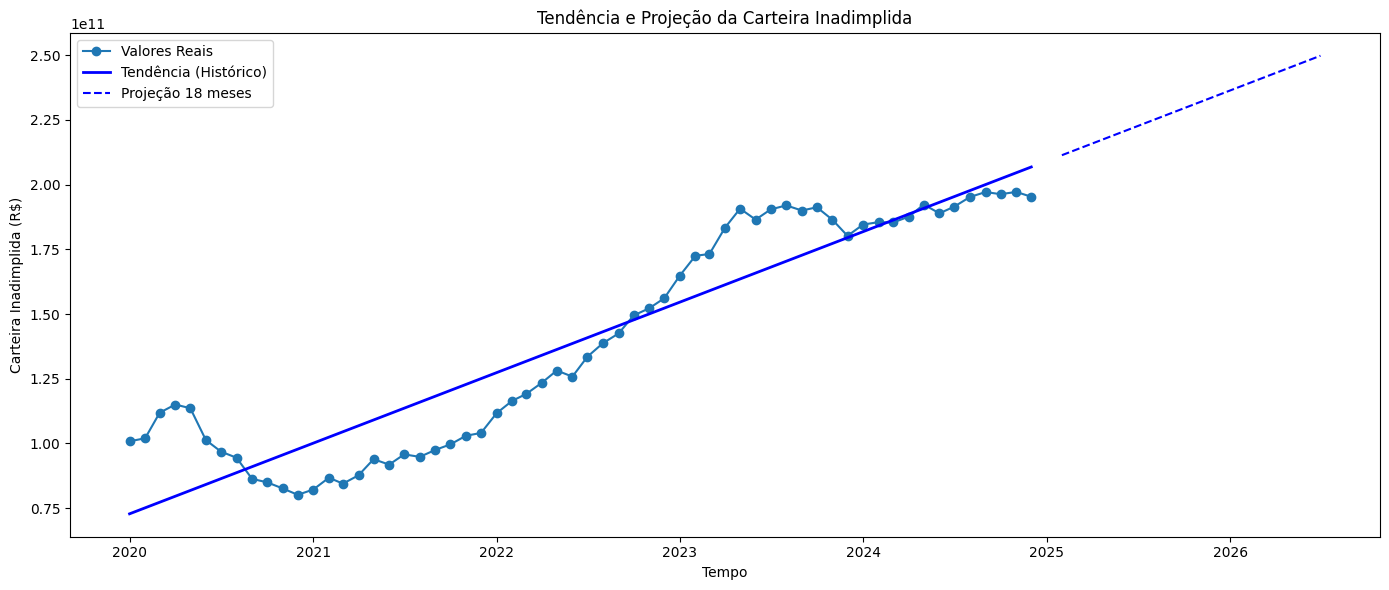

In [16]:
# Agregar por mês
df_mes = df.groupby(df["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mes["data_base"] = pd.to_datetime(df_mes["data_base"].astype(str))

# Transformar data em número ordinal
df_mes["mes_ordinal"] = df_mes["data_base"].map(lambda x: x.toordinal())

# Variáveis do modelo
X = df_mes["mes_ordinal"].values.reshape(-1, 1)
y = df_mes["soma_carteira_inadimplida_arrastada"].values

# Ajustar o modelo
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# ---- PROJEÇÃO FUTURA ----
# Última data do conjunto
ultima_data = df_mes["data_base"].max()
datas_futuras = pd.date_range(start=ultima_data + pd.DateOffset(months=1), periods=18, freq='ME')
futuro_ordinal = np.array([d.toordinal() for d in datas_futuras]).reshape(-1, 1)
y_pred_futuro = modelo.predict(futuro_ordinal)

# ---- VISUALIZAÇÃO ----
plt.figure(figsize=(14, 6))
# Dados históricos
plt.plot(df_mes["data_base"], y, label="Valores Reais", marker='o')
plt.plot(df_mes["data_base"], y_pred, label="Tendência (Histórico)", color="blue", linewidth=2)
# Projeção futura
plt.plot(datas_futuras, y_pred_futuro, label="Projeção 18 meses", color="blue", linestyle="dashed")

plt.xlabel("Tempo")
plt.ylabel("Carteira Inadimplida (R$)")
plt.title("Tendência e Projeção da Carteira Inadimplida")
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# Criar DataFrame com as previsões futuras
df_projecao = pd.DataFrame({
    "data": datas_futuras,
    "carteira_inadimplida_prevista": y_pred_futuro
})

# Salvar como CSV
df_projecao.to_csv("projecao_inadimplencia_18_meses.csv", index=False)

print("Arquivo 'projecao_inadimplencia_18_meses.csv' salvo com sucesso!")


Arquivo 'projecao_inadimplencia_18_meses.csv' salvo com sucesso!


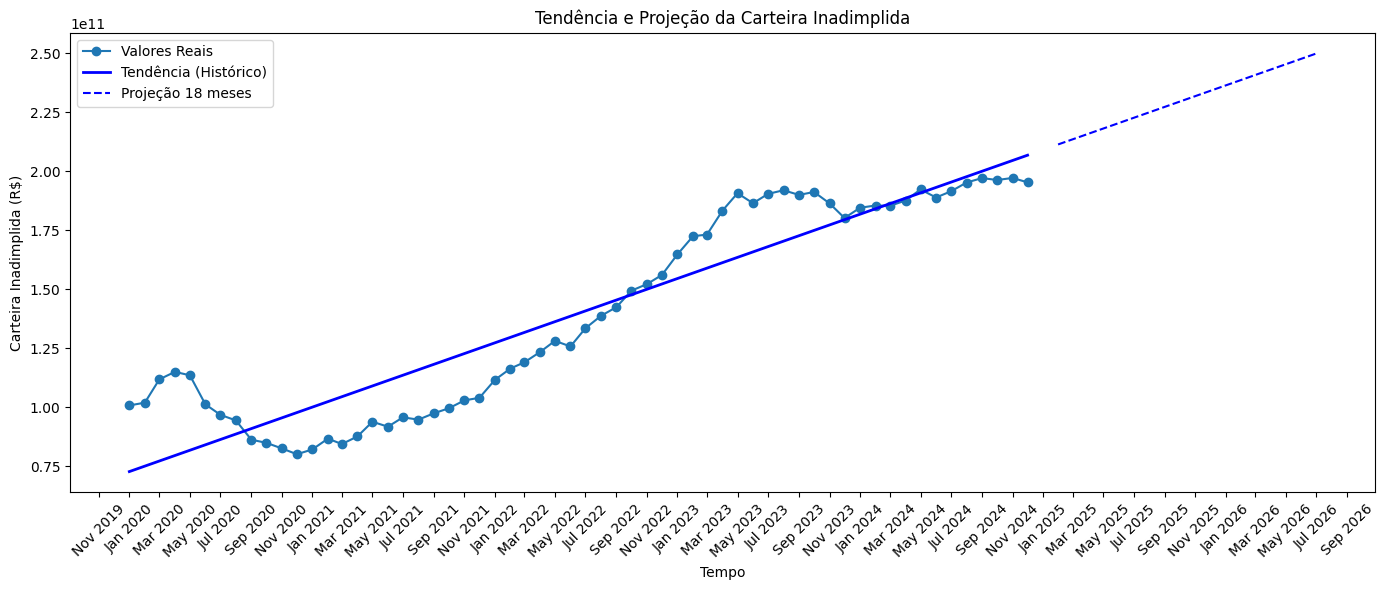

In [15]:
df["data_base"] = pd.to_datetime(df["data_base"])
df.groupby(df["data_base"].dt.to_period("M"))

# Converter para datetime antes de tudo
df["data_base"] = pd.to_datetime(df["data_base"])

# Agregar por mês
df_mes = df.groupby(df["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mes["data_base"] = pd.to_datetime(df_mes["data_base"].astype(str))  # Converter Period de volta para datetime

# Transformar data em número ordinal
df_mes["mes_ordinal"] = df_mes["data_base"].map(lambda x: x.toordinal())

# --- continua com o modelo e visualização ---
X = df_mes["mes_ordinal"].values.reshape(-1, 1)
y = df_mes["soma_carteira_inadimplida_arrastada"].values

# 4. Ajustar o modelo
modelo = LinearRegression()
modelo.fit(X, y)
y_pred = modelo.predict(X)

# 5. Projeção futura (18 meses à frente)
ultima_data = df_mes["data_base"].max()
datas_futuras = pd.date_range(start=ultima_data + pd.DateOffset(months=1), periods=18, freq='ME')
futuro_ordinal = np.array([d.toordinal() for d in datas_futuras]).reshape(-1, 1)
y_pred_futuro = modelo.predict(futuro_ordinal)

# 6. Visualização
plt.figure(figsize=(14, 6))
plt.plot(df_mes["data_base"], y, label="Valores Reais", marker='o')
plt.plot(df_mes["data_base"], y_pred, label="Tendência (Histórico)", color="blue", linewidth=2)
plt.plot(datas_futuras, y_pred_futuro, label="Projeção 18 meses", color="blue", linestyle="dashed")

plt.xlabel("Tempo")
plt.ylabel("Carteira Inadimplida (R$)")
plt.title("Tendência e Projeção da Carteira Inadimplida")
plt.legend()

# Formatar eixo X para exibir mês/ano
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Jan 2024, etc.
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))  # A cada 2 meses
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [16]:
# Criar DataFrame com projeções
df_proj = pd.DataFrame({
    "data_base": datas_futuras,
    "soma_carteira_inadimplida_arrastada": y_pred_futuro,
    "tipo": "Projeção"
})

# Adicionar coluna 'tipo' ao histórico
df_mes["tipo"] = "Histórico"

# Concatenar histórico + projeção
df_completo = pd.concat([df_mes[["data_base", "soma_carteira_inadimplida_arrastada", "tipo"]], df_proj])

# Salvar em CSV
df_completo.to_csv("carteira_inadimplida_com_projecao.csv", index=False)


In [ ]:
# Projeções com outros indicadores

In [21]:
# Análises Segmentadas (UF, porte, ocupação)
# Agrupamento por UF
print("\n📍 Inadimplência por UF:")
print(df.groupby("uf")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False))

# Agrupamento por porte
print("\n🏢 Inadimplência por Porte:")
print(df.groupby("porte")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False))

# Agrupamento por ocupação
print("\n👔 Inadimplência por Ocupação (Top 10):")
print(df.groupby("ocupacao")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False).head(10))

# Agrupamento por modalidade
print("\n💳 Inadimplência por Modalidade:")
print(df.groupby("modalidade")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False))



📍 Inadimplência por UF:
uf
SP    2.287110e+12
RJ    9.692739e+11
MG    6.740720e+11
PR    5.300748e+11
RS    4.648518e+11
BA    4.245257e+11
GO    3.645807e+11
SC    3.304958e+11
PE    2.972315e+11
CE    2.367845e+11
PA    2.082185e+11
MT    2.004818e+11
DF    2.004741e+11
MA    1.577536e+11
MS    1.472838e+11
ES    1.280050e+11
PB    1.233445e+11
RN    1.190890e+11
AM    1.076732e+11
AL    9.105980e+10
PI    8.036387e+10
SE    6.664642e+10
RO    6.131649e+10
TO    5.223952e+10
AP    2.497412e+10
AC    2.182713e+10
RR    1.804724e+10
Name: soma_carteira_inadimplida_arrastada, dtype: float64

🏢 Inadimplência por Porte:
porte
PF - Mais de 1 a 2 salários mínimos      1.437130e+12
PF - Mais de 3 a 5 salários mínimos      1.020819e+12
PF - Mais de 2 a 3 salários mínimos      8.864379e+11
PF - Mais de 5 a 10 salários mínimos     8.767416e+11
PJ - Pequeno                             8.224996e+11
PF - Até 1 salário mínimo                6.235443e+11
PJ - Médio                               6.

In [22]:
# Tendência Mensal da Inadimplência
# Agregar por mês
df_mensal = df.groupby(df["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mensal["data_base"] = pd.to_datetime(df_mensal["data_base"].astype(str))

print("\n📆 Tendência mensal da inadimplência (valores totais por mês):")
print(df_mensal.sort_values("data_base"))



📆 Tendência mensal da inadimplência (valores totais por mês):
    data_base  soma_carteira_inadimplida_arrastada
0  2020-01-01                         1.008392e+11
1  2020-02-01                         1.020084e+11
2  2020-03-01                         1.118839e+11
3  2020-04-01                         1.150491e+11
4  2020-05-01                         1.136140e+11
5  2020-06-01                         1.013122e+11
6  2020-07-01                         9.685873e+10
7  2020-08-01                         9.448900e+10
8  2020-09-01                         8.631703e+10
9  2020-10-01                         8.499374e+10
10 2020-11-01                         8.262267e+10
11 2020-12-01                         8.016589e+10
12 2021-01-01                         8.220681e+10
13 2021-02-01                         8.676739e+10
14 2021-03-01                         8.447779e+10
15 2021-04-01                         8.769893e+10
16 2021-05-01                         9.392601e+10
17 2021-06-01      

In [24]:
# Correlações entre Indicadores Financeiros
# Selecionar colunas numéricas relevantes para análise de correlação
colunas_corr = [
    'soma_a_vencer_ate_90_dias', 'soma_numero_de_operacoes',
    'soma_carteira_ativa', 'soma_carteira_inadimplida_arrastada',
    'soma_ativo_problematico'
]

# Calcular correlação de Pearson
print("\n🔗 Correlação entre indicadores financeiros:")
print(df[colunas_corr].corr())



🔗 Correlação entre indicadores financeiros:
                                     soma_a_vencer_ate_90_dias  \
soma_a_vencer_ate_90_dias                             1.000000   
soma_numero_de_operacoes                              0.397301   
soma_carteira_ativa                                   0.604829   
soma_carteira_inadimplida_arrastada                   0.407955   
soma_ativo_problematico                               0.333746   

                                     soma_numero_de_operacoes  \
soma_a_vencer_ate_90_dias                            0.397301   
soma_numero_de_operacoes                             1.000000   
soma_carteira_ativa                                  0.192798   
soma_carteira_inadimplida_arrastada                  0.585141   
soma_ativo_problematico                              0.244249   

                                     soma_carteira_ativa  \
soma_a_vencer_ate_90_dias                       0.604829   
soma_numero_de_operacoes                       

C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\3661327000.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


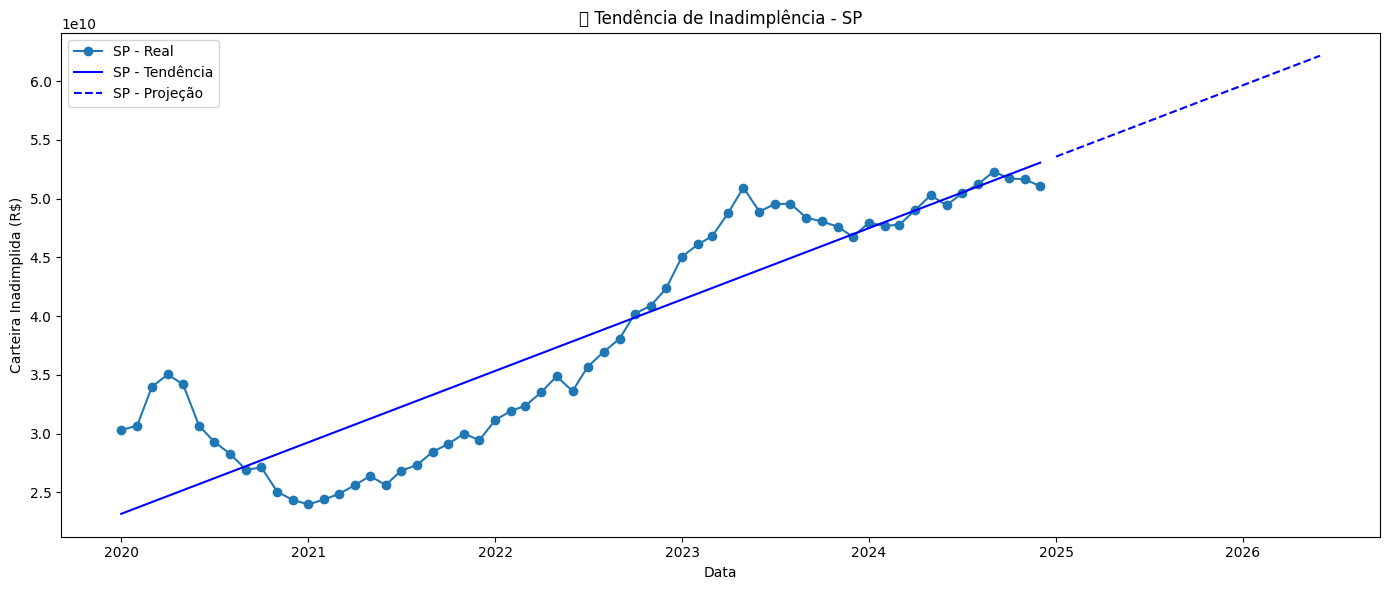

In [54]:
# Filtrar por UF
df_sp = df[df["uf"] == "SP"]

# Agrupar por mês
df_sp_mes = df_sp.groupby(df_sp["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_sp_mes["data_base"] = pd.to_datetime(df_sp_mes["data_base"].astype(str))
df_sp_mes["mes_ordinal"] = df_sp_mes["data_base"].map(lambda x: x.toordinal())

# Regressão
X_sp = df_sp_mes["mes_ordinal"].values.reshape(-1, 1)
y_sp = df_sp_mes["soma_carteira_inadimplida_arrastada"].values
modelo_sp = LinearRegression().fit(X_sp, y_sp)
y_pred_sp = modelo_sp.predict(X_sp)

# Projeção futura
ultima_data_sp = df_sp_mes["data_base"].max()
datas_futuras_sp = pd.date_range(start=ultima_data_sp + pd.DateOffset(months=1), periods=18, freq='MS')
futuro_ordinal_sp = np.array([d.toordinal() for d in datas_futuras_sp]).reshape(-1, 1)
y_pred_futuro_sp = modelo_sp.predict(futuro_ordinal_sp)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_sp_mes["data_base"], y_sp, label="SP - Real", marker='o')
plt.plot(df_sp_mes["data_base"], y_pred_sp, label="SP - Tendência", color="blue")
plt.plot(datas_futuras_sp, y_pred_futuro_sp, label="SP - Projeção", linestyle="dashed", color="blue")
plt.title("📈 Tendência de Inadimplência - SP")
plt.xlabel("Data")
plt.ylabel("Carteira Inadimplida (R$)")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\1960202012.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


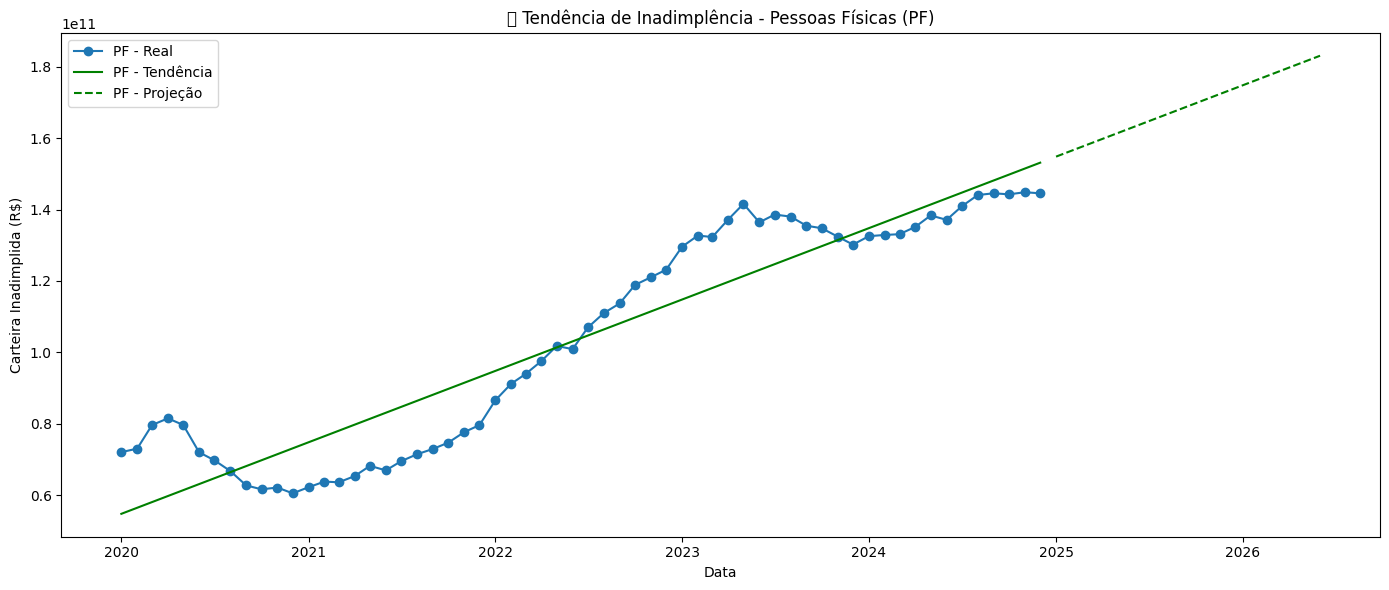

In [55]:
# Filtrar por PF
df_pf = df[df["porte"].str.startswith("PF")]

# Agrupar por mês
df_pf_mes = df_pf.groupby(df_pf["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_pf_mes["data_base"] = pd.to_datetime(df_pf_mes["data_base"].astype(str))
df_pf_mes["mes_ordinal"] = df_pf_mes["data_base"].map(lambda x: x.toordinal())

# Regressão
X_pf = df_pf_mes["mes_ordinal"].values.reshape(-1, 1)
y_pf = df_pf_mes["soma_carteira_inadimplida_arrastada"].values
modelo_pf = LinearRegression().fit(X_pf, y_pf)
y_pred_pf = modelo_pf.predict(X_pf)

# Projeção futura
ultima_data_pf = df_pf_mes["data_base"].max()
datas_futuras_pf = pd.date_range(start=ultima_data_pf + pd.DateOffset(months=1), periods=18, freq='MS')
futuro_ordinal_pf = np.array([d.toordinal() for d in datas_futuras_pf]).reshape(-1, 1)
y_pred_futuro_pf = modelo_pf.predict(futuro_ordinal_pf)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_pf_mes["data_base"], y_pf, label="PF - Real", marker='o')
plt.plot(df_pf_mes["data_base"], y_pred_pf, label="PF - Tendência", color="green")
plt.plot(datas_futuras_pf, y_pred_futuro_pf, label="PF - Projeção", linestyle="dashed", color="green")
plt.title("📈 Tendência de Inadimplência - Pessoas Físicas (PF)")
plt.xlabel("Data")
plt.ylabel("Carteira Inadimplida (R$)")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\652866114.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


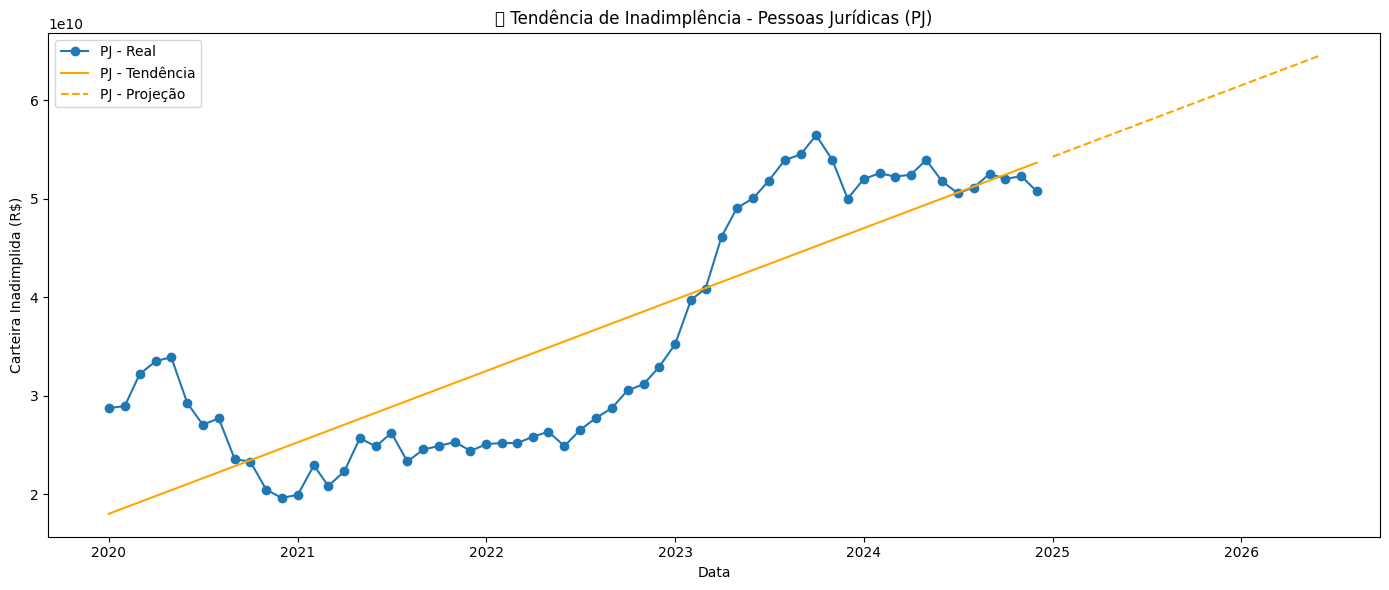

In [56]:
# Filtrar por PJ
df_pj = df[df["porte"].str.startswith("PJ")]

# Agrupar por mês
df_pj_mes = df_pj.groupby(df_pj["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_pj_mes["data_base"] = pd.to_datetime(df_pj_mes["data_base"].astype(str))
df_pj_mes["mes_ordinal"] = df_pj_mes["data_base"].map(lambda x: x.toordinal())

# Regressão
X_pj = df_pj_mes["mes_ordinal"].values.reshape(-1, 1)
y_pj = df_pj_mes["soma_carteira_inadimplida_arrastada"].values
modelo_pj = LinearRegression().fit(X_pj, y_pj)
y_pred_pj = modelo_pj.predict(X_pj)

# Projeção futura
ultima_data_pj = df_pj_mes["data_base"].max()
datas_futuras_pj = pd.date_range(start=ultima_data_pj + pd.DateOffset(months=1), periods=18, freq='MS')
futuro_ordinal_pj = np.array([d.toordinal() for d in datas_futuras_pj]).reshape(-1, 1)
y_pred_futuro_pj = modelo_pj.predict(futuro_ordinal_pj)

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_pj_mes["data_base"], y_pj, label="PJ - Real", marker='o')
plt.plot(df_pj_mes["data_base"], y_pred_pj, label="PJ - Tendência", color="orange")
plt.plot(datas_futuras_pj, y_pred_futuro_pj, label="PJ - Projeção", linestyle="dashed", color="orange")
plt.title("📈 Tendência de Inadimplência - Pessoas Jurídicas (PJ)")
plt.xlabel("Data")
plt.ylabel("Carteira Inadimplida (R$)")
plt.legend()
plt.tight_layout()
plt.show()


📌 Correlações com a inadimplência (soma_carteira_inadimplida_arrastada):
soma_carteira_inadimplida_arrastada     1.000000
max_carteira_inadimplida_arrastada      0.907300
media_carteira_inadimplida_arrastada    0.605791
max_numero_de_operacoes                 0.585371
soma_numero_de_operacoes                0.585141
soma_ativo_problematico                 0.553998
media_numero_de_operacoes               0.545366
max_ativo_problematico                  0.534323
max_a_vencer_ate_90_dias                0.452692
media_a_vencer_ate_90_dias              0.427155
soma_a_vencer_ate_90_dias               0.407955
soma_carteira_ativa                     0.385576
max_carteira_ativa                      0.349767
media_ativo_problematico                0.194514
media_carteira_ativa                    0.189924
min_carteira_inadimplida_arrastada      0.022741
min_ativo_problematico                  0.001403
min_numero_de_operacoes                -0.003185
min_carteira_ativa                     -0.005

C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\2906570638.py:19: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


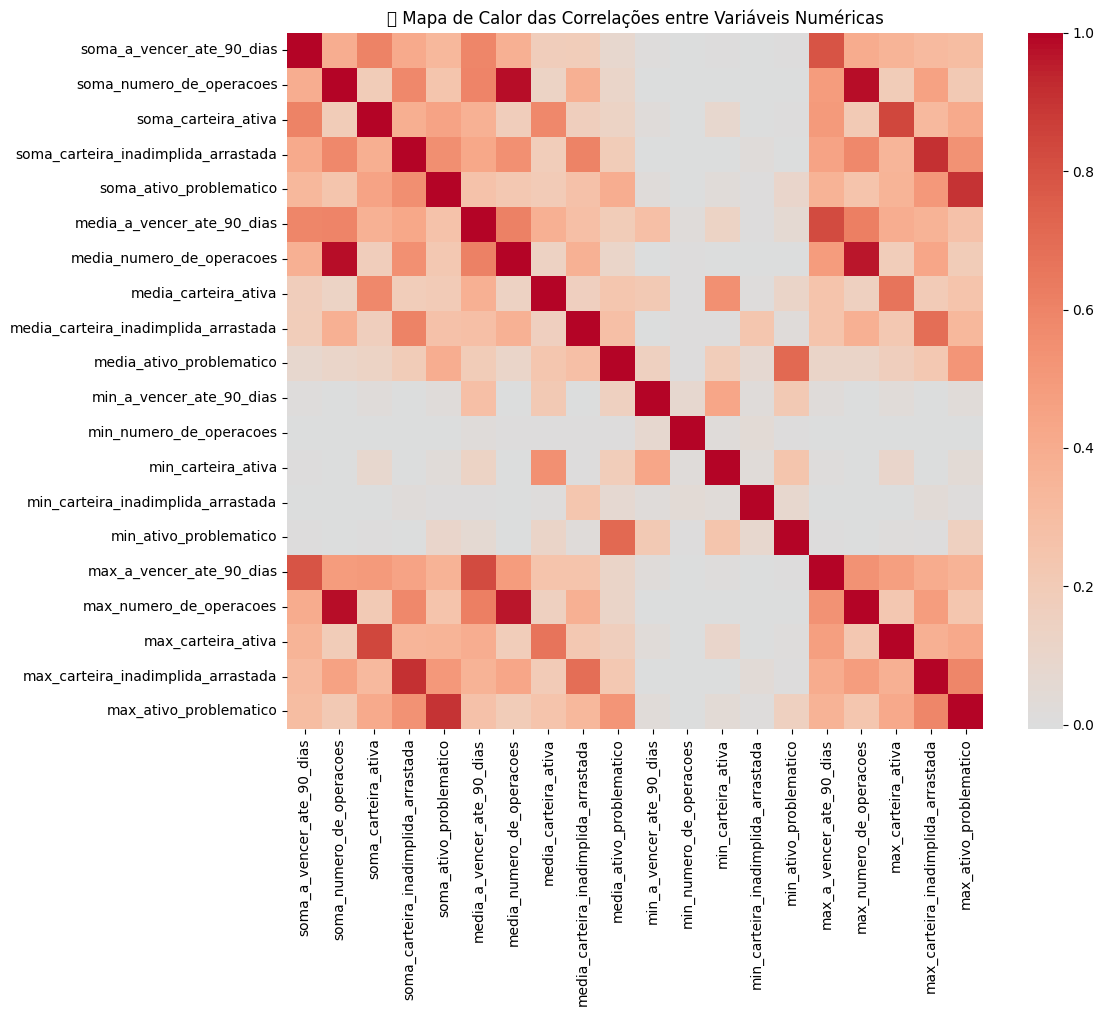

In [30]:
# Selecionar apenas colunas numéricas
df_numerico = df.select_dtypes(include=["number"])

# Calcular a matriz de correlação
correlacoes = df_numerico.corr()

# Exibir correlações com a inadimplência (em ordem decrescente)
correl_com_inad = correlacoes["soma_carteira_inadimplida_arrastada"].sort_values(ascending=False)
print("📌 Correlações com a inadimplência (soma_carteira_inadimplida_arrastada):")
print(correl_com_inad)

# Gerar o heatmap completo
plt.figure(figsize=(12, 10))
sns.heatmap(correlacoes, cmap="coolwarm", center=0, annot=False, fmt=".2f", square=True)
plt.title("🧠 Mapa de Calor das Correlações entre Variáveis Numéricas")
plt.tight_layout()
plt.show()


In [31]:
# Remover a própria variável da comparação
correl_inad = correl_com_inad.drop("soma_carteira_inadimplida_arrastada")

# Top 5 maiores correlações positivas
top_positivas = correl_inad.sort_values(ascending=False).head(5)
print("🔝 Top 5 correlações positivas com inadimplência:")
print(top_positivas)

# Top 5 maiores correlações negativas
top_negativas = correl_inad.sort_values().head(5)
print("\n🔻 Top 5 correlações negativas com inadimplência:")
print(top_negativas)


🔝 Top 5 correlações positivas com inadimplência:
max_carteira_inadimplida_arrastada      0.907300
media_carteira_inadimplida_arrastada    0.605791
max_numero_de_operacoes                 0.585371
soma_numero_de_operacoes                0.585141
soma_ativo_problematico                 0.553998
Name: soma_carteira_inadimplida_arrastada, dtype: float64

🔻 Top 5 correlações negativas com inadimplência:
min_a_vencer_ate_90_dias             -0.006088
min_carteira_ativa                   -0.005664
min_numero_de_operacoes              -0.003185
min_ativo_problematico                0.001403
min_carteira_inadimplida_arrastada    0.022741
Name: soma_carteira_inadimplida_arrastada, dtype: float64


porte
PF    6.236499e+12
PJ    2.151300e+12
Name: soma_carteira_inadimplida_arrastada, dtype: float64


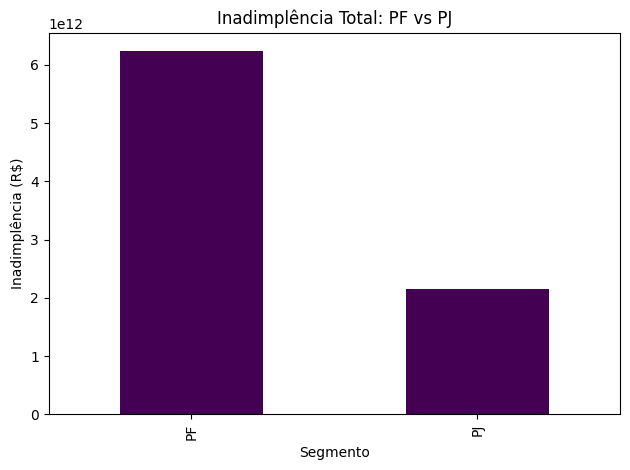

In [32]:
inad_por_pf_pj = df.groupby(df["porte"].str[:2])["soma_carteira_inadimplida_arrastada"].sum()
print(inad_por_pf_pj)
inad_por_pf_pj.plot(kind="bar", title="Inadimplência Total: PF vs PJ", ylabel="Inadimplência (R$)", xlabel="Segmento", colormap="viridis")
plt.tight_layout()
plt.show()


porte              PF            PJ
ano_mes                            
2024-08  1.440792e+11  5.116587e+10
2024-09  1.445676e+11  5.257282e+10
2024-10  1.442768e+11  5.203859e+10
2024-11  1.448655e+11  5.232254e+10
2024-12  1.445596e+11  5.076447e+10


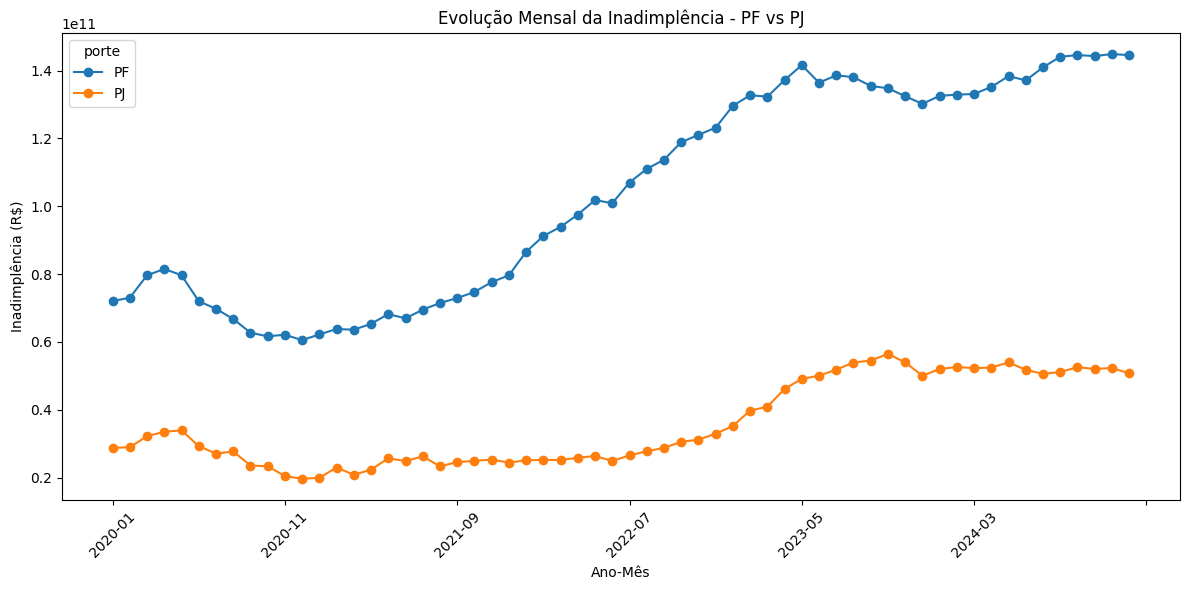

In [34]:
df["ano_mes"] = df["data_base"].dt.to_period("M").astype(str)
evolucao_pf_pj = df.groupby(["ano_mes", df["porte"].str[:2]])["soma_carteira_inadimplida_arrastada"].sum().unstack()
print(evolucao_pf_pj.tail())
evolucao_pf_pj.plot(figsize=(12,6), marker="o", title="Evolução Mensal da Inadimplência - PF vs PJ")
plt.ylabel("Inadimplência (R$)")
plt.xlabel("Ano-Mês")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


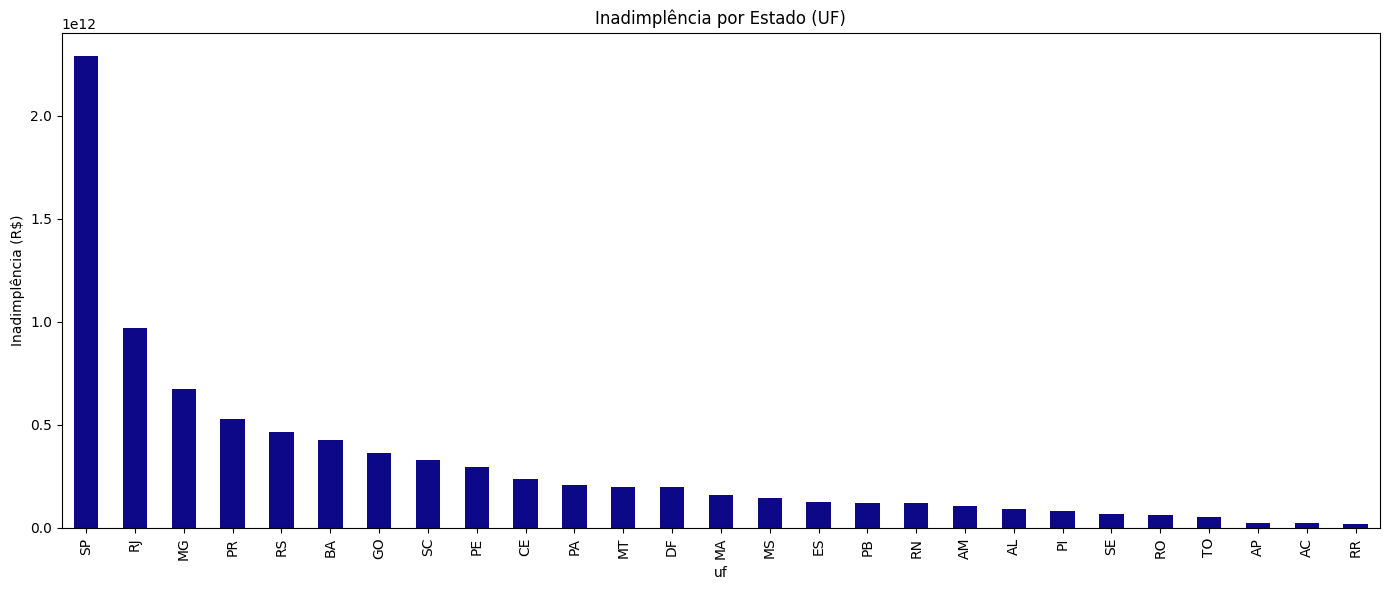

In [35]:
inad_por_uf = df.groupby("uf")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False)

inad_por_uf.plot(kind="bar", figsize=(14,6), title="Inadimplência por Estado (UF)", ylabel="Inadimplência (R$)", colormap="plasma")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


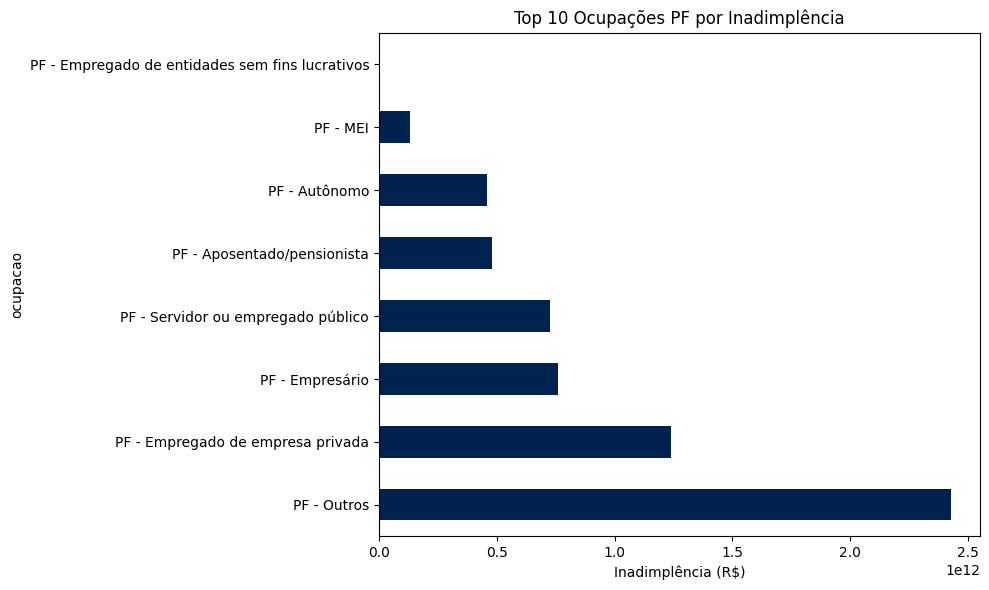

In [36]:
ocup_pf = df[df["porte"].str.contains("PF")]
top_ocup_pf = ocup_pf.groupby("ocupacao")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False).head(10)

top_ocup_pf.plot(kind="barh", title="Top 10 Ocupações PF por Inadimplência", figsize=(10,6), colormap="cividis")
plt.xlabel("Inadimplência (R$)")
plt.tight_layout()
plt.show()


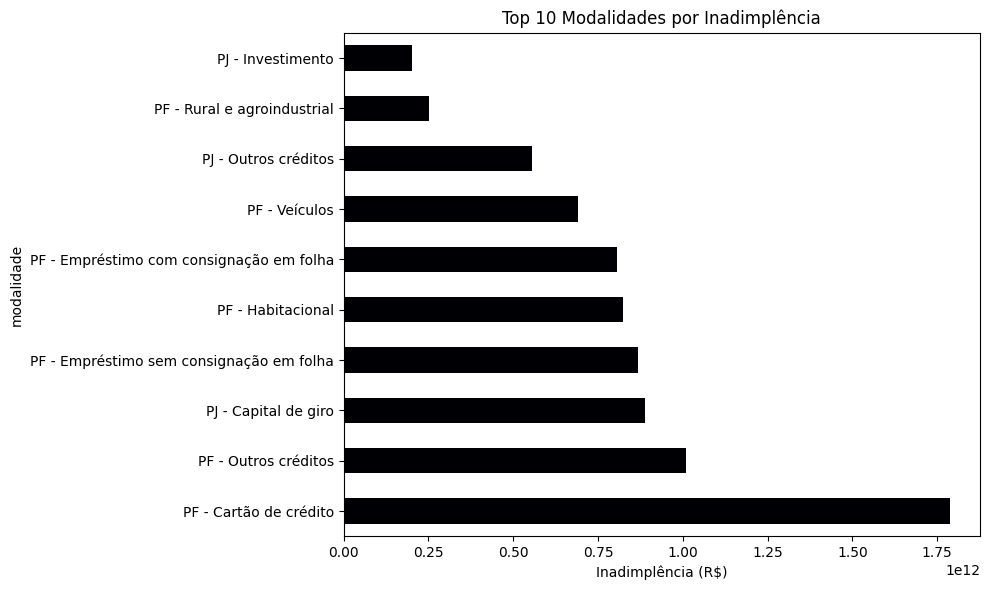

In [37]:
top_modal = df.groupby("modalidade")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False).head(10)

top_modal.plot(kind="barh", title="Top 10 Modalidades por Inadimplência", figsize=(10,6), colormap="magma")
plt.xlabel("Inadimplência (R$)")
plt.tight_layout()
plt.show()


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\2712322971.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


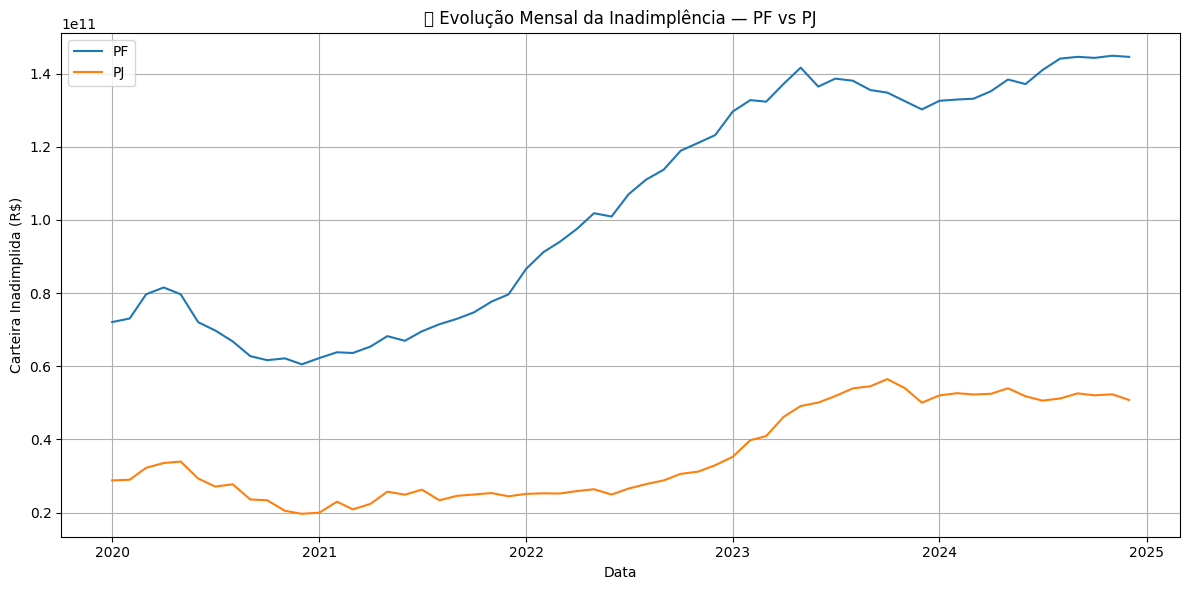

📊 Inadimplência total por segmento (PF/PJ):
porte
PF    6.236499e+12
PJ    2.151300e+12
Name: soma_carteira_inadimplida_arrastada, dtype: float64


In [39]:
# Extrair o tipo (PF/PJ)
df["segmento"] = df["porte"].str[:2]

# Agrupar por mês e segmento
df_mensal = df.groupby([df["data_base"].dt.to_period("M"), "segmento"])["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mensal["data_base"] = df_mensal["data_base"].astype(str)
df_mensal["data_base"] = pd.to_datetime(df_mensal["data_base"])

# Gráfico de linha
plt.figure(figsize=(12, 6))
for segmento in ["PF", "PJ"]:
    dados = df_mensal[df_mensal["segmento"] == segmento]
    plt.plot(dados["data_base"], dados["soma_carteira_inadimplida_arrastada"], label=segmento)

plt.title("📈 Evolução Mensal da Inadimplência — PF vs PJ")
plt.xlabel("Data")
plt.ylabel("Carteira Inadimplida (R$)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()

inad_por_pf_pj = df.groupby(df["porte"].str[:2])["soma_carteira_inadimplida_arrastada"].sum()
print("📊 Inadimplência total por segmento (PF/PJ):")
print(inad_por_pf_pj)


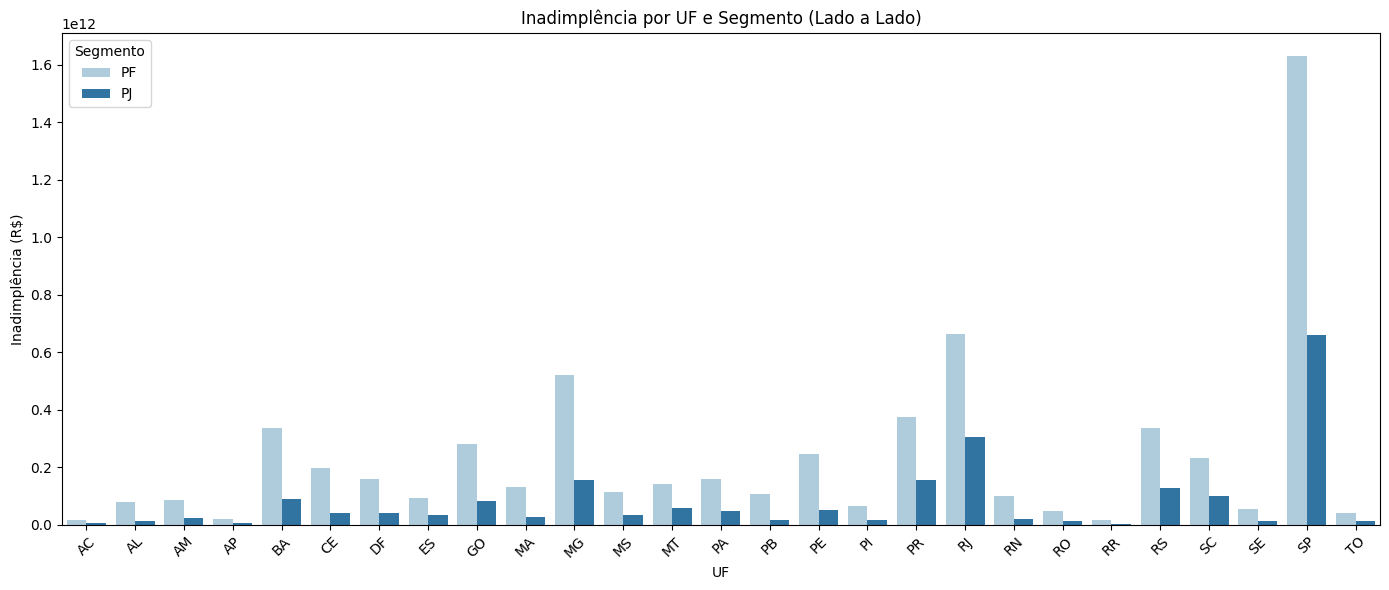

📍 Top 10 UFs com maior inadimplência por segmento:
    uf segmento  soma_carteira_inadimplida_arrastada
50  SP       PF                         1.628729e+12
36  RJ       PF                         6.640344e+11
51  SP       PJ                         6.583817e+11
20  MG       PF                         5.194709e+11
34  PR       PF                         3.730798e+11
8   BA       PF                         3.364601e+11
44  RS       PF                         3.355325e+11
37  RJ       PJ                         3.052396e+11
16  GO       PF                         2.809680e+11
30  PE       PF                         2.442874e+11
46  SC       PF                         2.317465e+11
10  CE       PF                         1.956475e+11
35  PR       PJ                         1.569950e+11
21  MG       PJ                         1.546011e+11
45  RS       PJ                         1.293193e+11
47  SC       PJ                         9.874926e+10
9   BA       PJ                         8.806560

In [44]:
plt.figure(figsize=(14, 6))
sns.barplot(
    data=inad_uf_segmento,
    x="uf",
    y="soma_carteira_inadimplida_arrastada",
    hue="segmento",
    palette="Paired"
)
plt.title("Inadimplência por UF e Segmento (Lado a Lado)")
plt.xlabel("UF")
plt.ylabel("Inadimplência (R$)")
plt.xticks(rotation=45)
plt.legend(title="Segmento")
plt.tight_layout()
plt.show()

# Agrupar por UF e segmento
inad_uf_segmento = df.groupby(["uf", "segmento"])["soma_carteira_inadimplida_arrastada"].sum().reset_index()

# Ordenar e visualizar
print("📍 Top 10 UFs com maior inadimplência por segmento:")
top_ufs = inad_uf_segmento.sort_values(by="soma_carteira_inadimplida_arrastada", ascending=False).groupby("segmento").head(10)
print(top_ufs)
import matplotlib.pyplot as plt


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\3524095163.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=inad_ocupacao.values, y=inad_ocupacao.index, palette="magma")
C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\3524095163.py:16: UserWarning: Glyph 128084 (\N{NECKTIE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128084 (\N{NECKTIE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


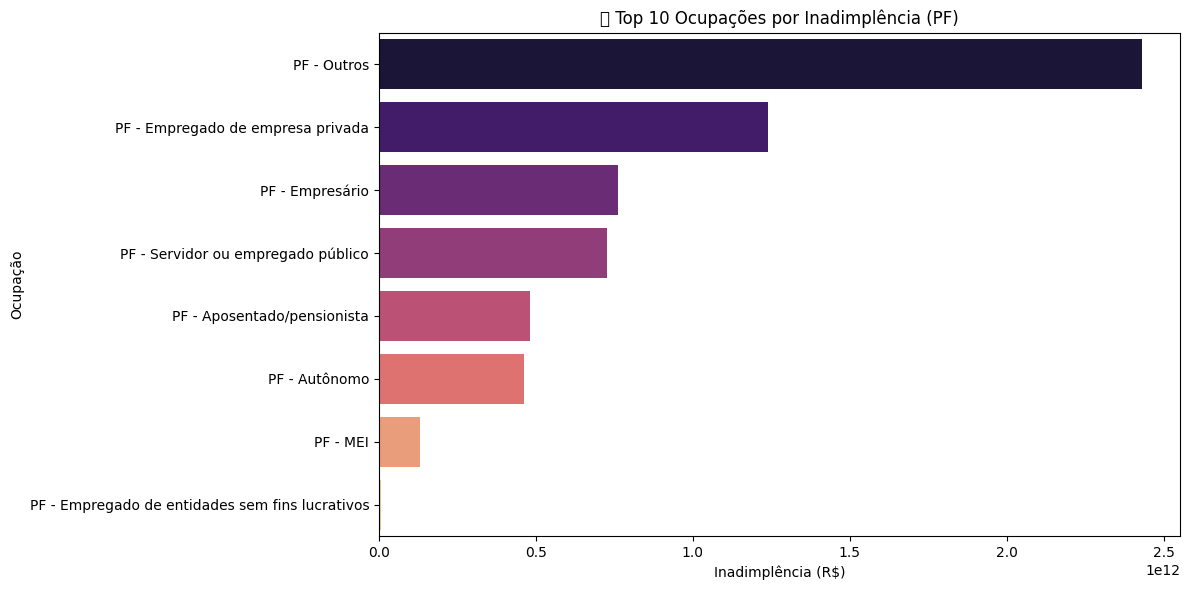

In [46]:
# Filtrar apenas dados do segmento PF
df_pf = df[df["porte"].str.startswith("PF")]

# Agrupar por ocupação
inad_ocupacao = df_pf.groupby("ocupacao")["soma_carteira_inadimplida_arrastada"].sum().sort_values(ascending=False).head(10)

# Plotar gráfico

plt.figure(figsize=(12, 6))
sns.barplot(x=inad_ocupacao.values, y=inad_ocupacao.index, palette="magma")
plt.title("👔 Top 10 Ocupações por Inadimplência (PF)")
plt.xlabel("Inadimplência (R$)")
plt.ylabel("Ocupação")
plt.tight_layout()
plt.show()


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\1699066250.py:30: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


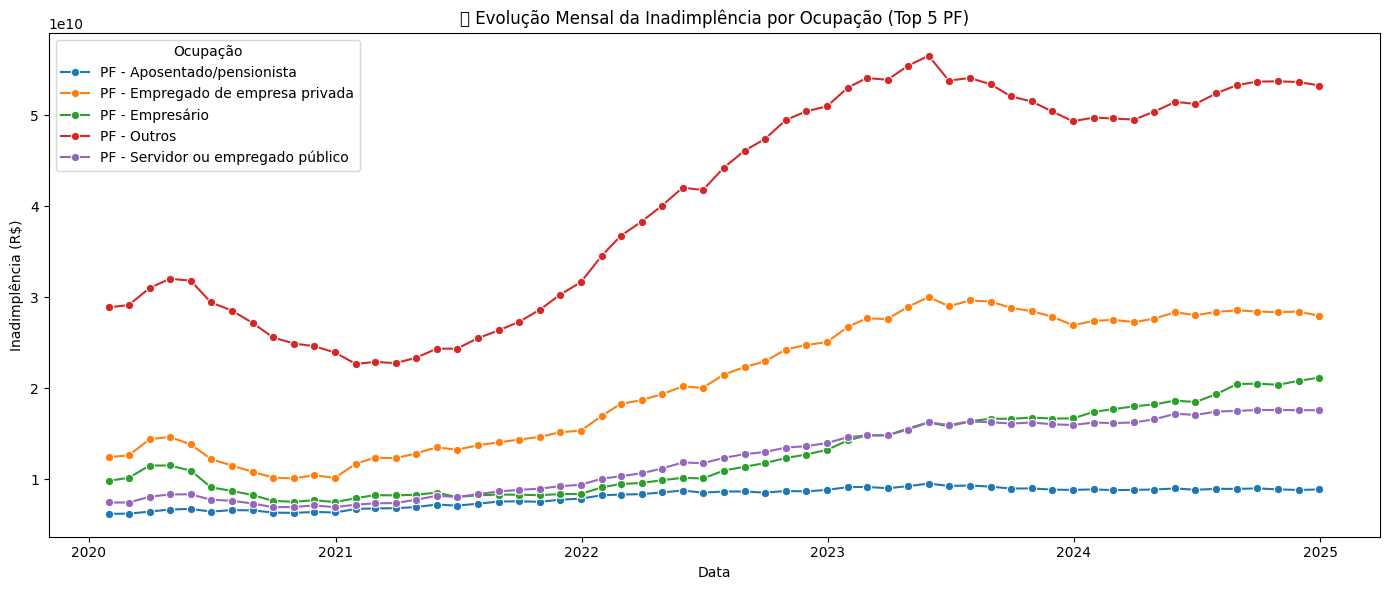

In [49]:
# Filtrar PF
df_pf = df[df["porte"].str.startswith("PF")]

# Top 5 ocupações com maior inadimplência total
top_ocupacoes = (
    df_pf.groupby("ocupacao")["soma_carteira_inadimplida_arrastada"]
    .sum()
    .sort_values(ascending=False)
    .head(5)
    .index
)

# Filtrar dados dessas ocupações
df_top_ocupacoes = df_pf[df_pf["ocupacao"].isin(top_ocupacoes)]

# Agrupar por mês e ocupação
df_evolucao = (
    df_top_ocupacoes.groupby(["data_base", "ocupacao"])["soma_carteira_inadimplida_arrastada"]
    .sum()
    .reset_index()
)

# Plotar gráfico
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_evolucao, x="data_base", y="soma_carteira_inadimplida_arrastada", hue="ocupacao", marker="o")
plt.title("📈 Evolução Mensal da Inadimplência por Ocupação (Top 5 PF)")
plt.ylabel("Inadimplência (R$)")
plt.xlabel("Data")
plt.legend(title="Ocupação")
plt.tight_layout()
plt.show()


C:\Users\AU355EE\AppData\Local\Temp\ipykernel_10728\613375899.py:29: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


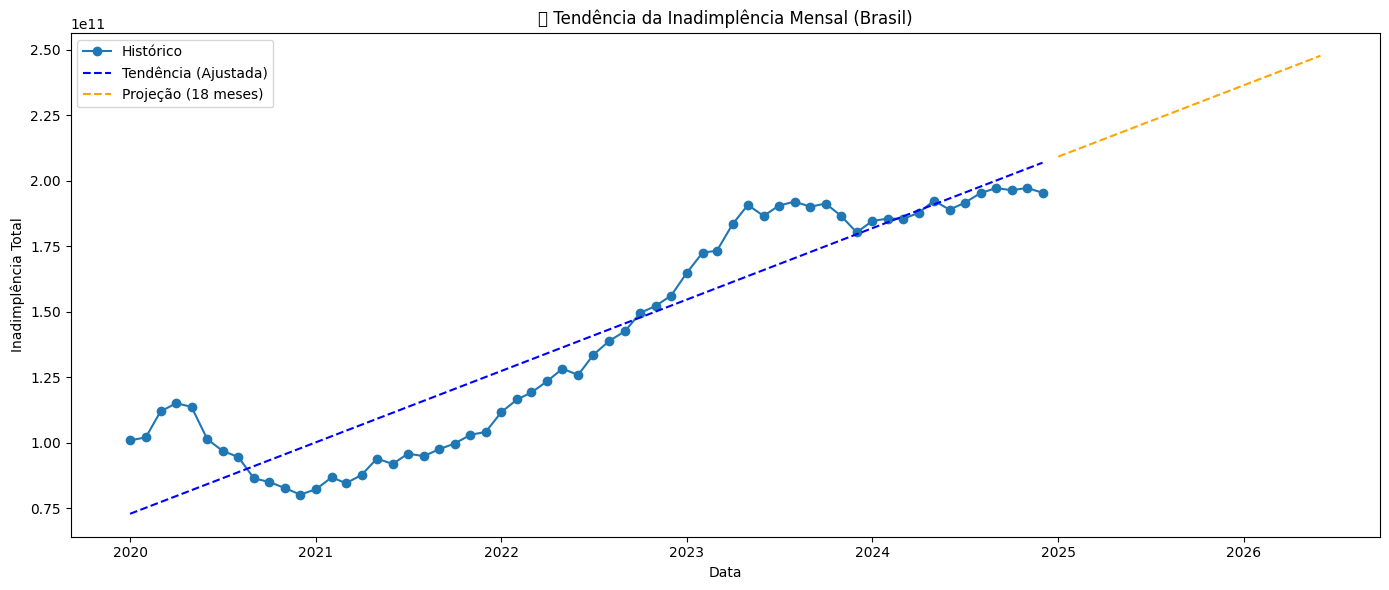

In [57]:

# Etapa 1: Agregação mensal
df_mensal = df.groupby(df["data_base"].dt.to_period("M"))["soma_carteira_inadimplida_arrastada"].sum().reset_index()
df_mensal["data_base"] = pd.to_datetime(df_mensal["data_base"].astype(str))

# Etapa 2: Transformar datas em números para regressão
df_mensal["mes_ordinal"] = df_mensal["data_base"].map(lambda x: x.toordinal())
X = df_mensal["mes_ordinal"].values.reshape(-1, 1)
y = df_mensal["soma_carteira_inadimplida_arrastada"].values

# Etapa 3: Treinar o modelo
modelo = LinearRegression()
modelo.fit(X, y)

# Etapa 4: Projeção para os próximos 18 meses
last_date = df_mensal["data_base"].max()
futuras_datas = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=18, freq="MS")
futuras_ordinais = futuras_datas.map(lambda x: x.toordinal()).values.reshape(-1, 1)
y_pred_futuro = modelo.predict(futuras_ordinais)

# Etapa 5: Plotar
plt.figure(figsize=(14, 6))
plt.plot(df_mensal["data_base"], y, label="Histórico", marker='o')
plt.plot(df_mensal["data_base"], modelo.predict(X), label="Tendência (Ajustada)", color="blue", linestyle='--')
plt.plot(futuras_datas, y_pred_futuro, label="Projeção (18 meses)", color="orange", linestyle='--')
plt.title("📈 Tendência da Inadimplência Mensal (Brasil)")
plt.xlabel("Data")
plt.ylabel("Inadimplência Total")
plt.legend()
plt.tight_layout()
plt.show()


R² para SP: 0.8063


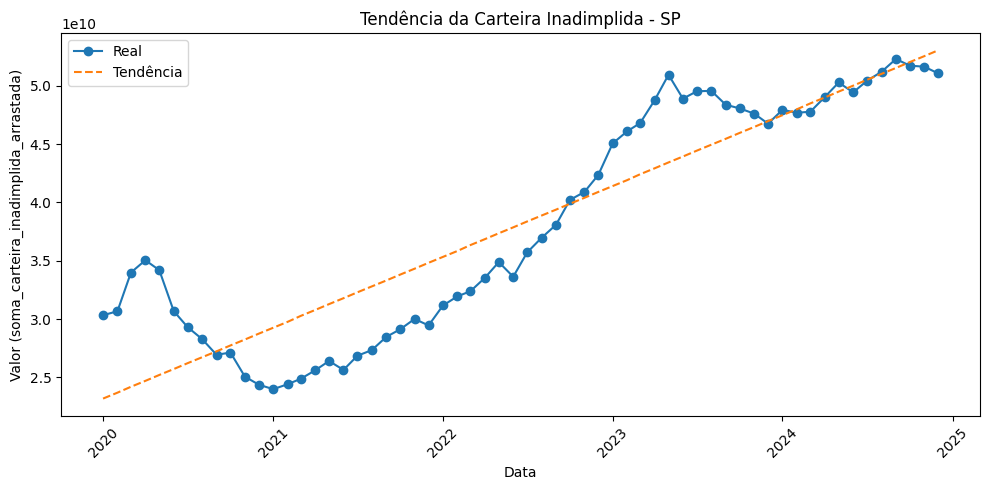

In [59]:
# Projeção da inadimplencia pra os prox 18 meses em SP
# Passo 1: Preparar o dataframe
df['data_base'] = pd.to_datetime(df['data_base'])
df['ano_mes'] = df['data_base'].dt.to_period('M').dt.to_timestamp()

# Passo 2: Agregar por UF e mês
df_uf = df.groupby(['uf', 'ano_mes'])['soma_carteira_inadimplida_arrastada'].sum().reset_index()

uf = 'SP'  # ou qualquer outra, como 'RJ', 'MG', etc.
df_uf_sp = df_uf[df_uf['uf'] == uf].copy()
df_uf_sp['mes_num'] = np.arange(len(df_uf_sp))  # variável de tempo

# Modelo
X = df_uf_sp[['mes_num']]
y = df_uf_sp['soma_carteira_inadimplida_arrastada']
modelo = LinearRegression()
modelo.fit(X, y)
df_uf_sp['tendencia'] = modelo.predict(X)

# Avaliação
r2 = r2_score(y, df_uf_sp['tendencia'])
print(f'R² para {uf}: {r2:.4f}')

plt.figure(figsize=(10,5))
plt.plot(df_uf_sp['ano_mes'], df_uf_sp['soma_carteira_inadimplida_arrastada'], marker='o', label='Real')
plt.plot(df_uf_sp['ano_mes'], df_uf_sp['tendencia'], linestyle='--', label='Tendência')
plt.title(f'Tendência da Carteira Inadimplida - {uf}')
plt.xlabel('Data')
plt.ylabel('Valor (soma_carteira_inadimplida_arrastada)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


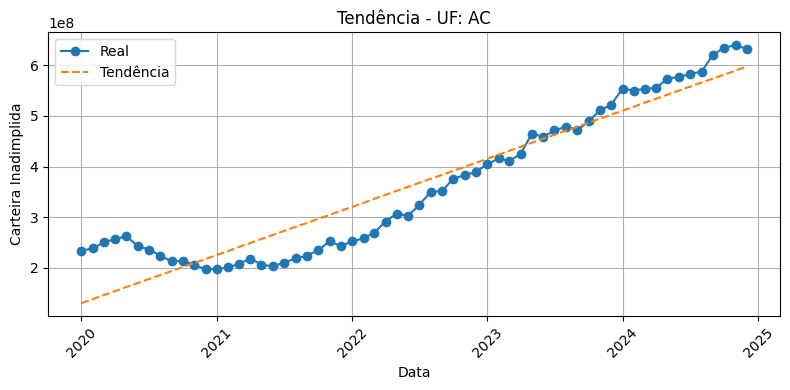

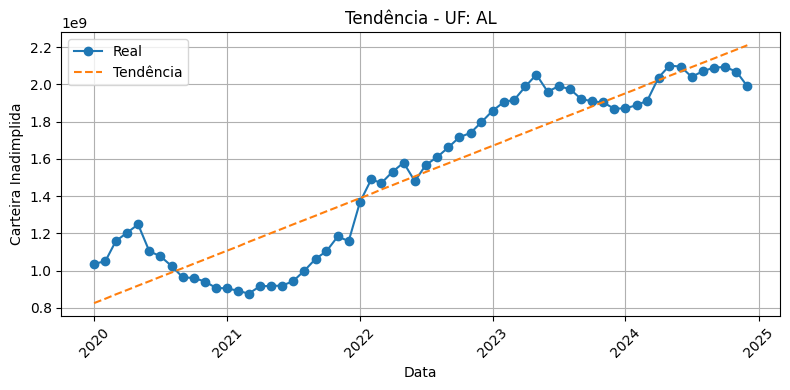

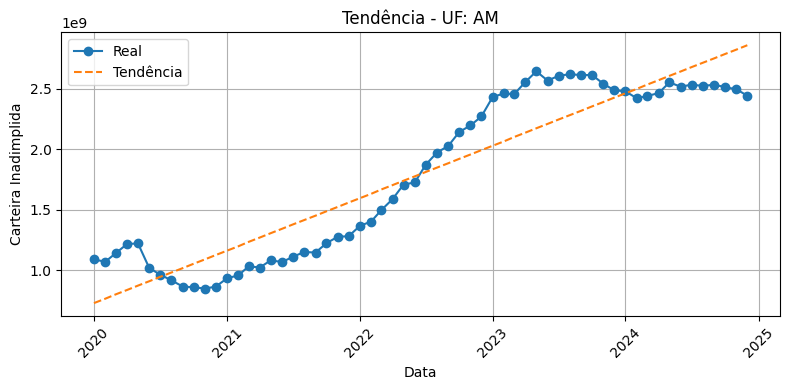

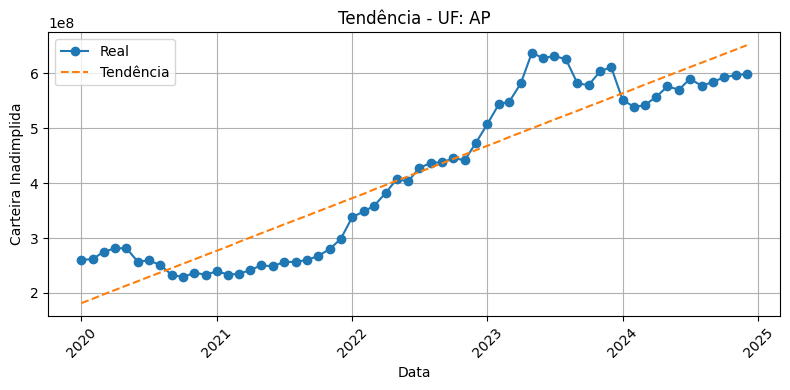

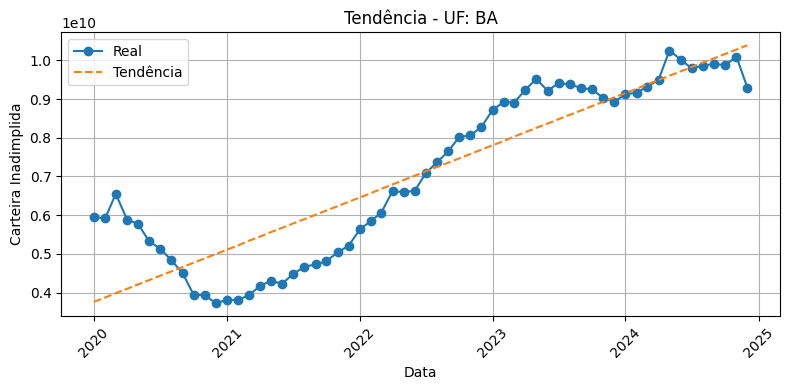

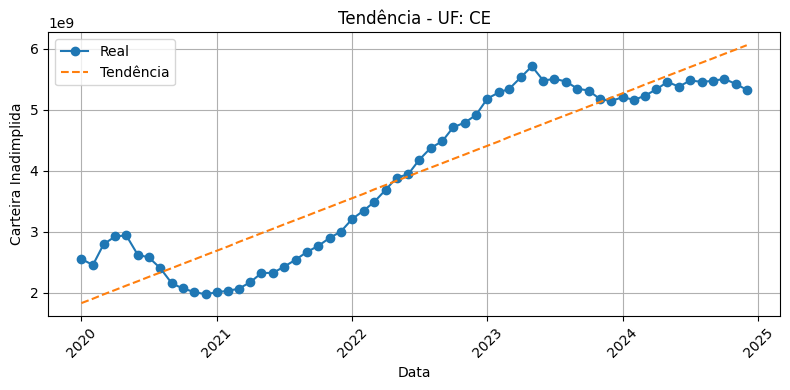

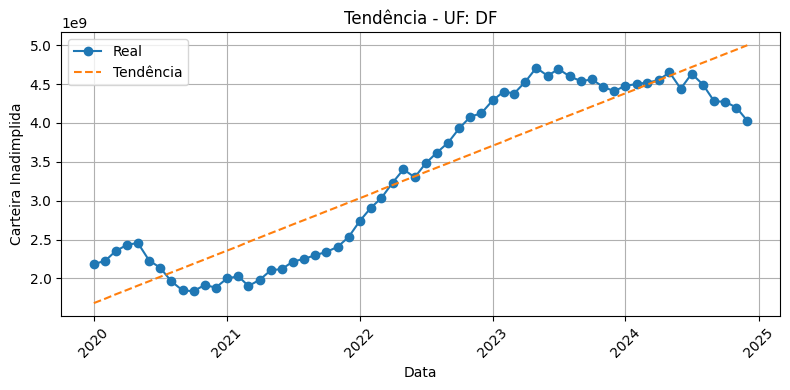

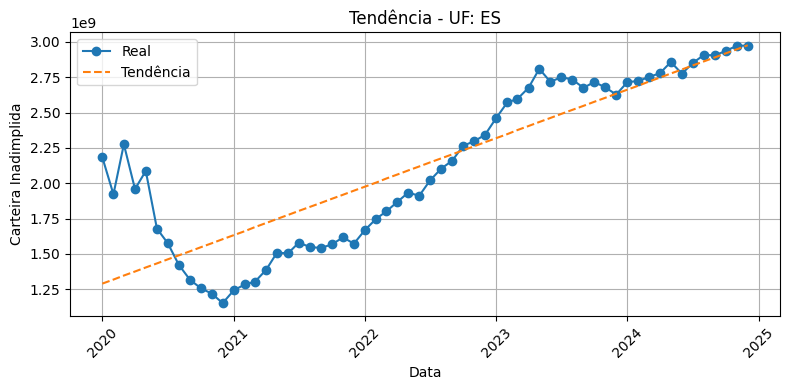

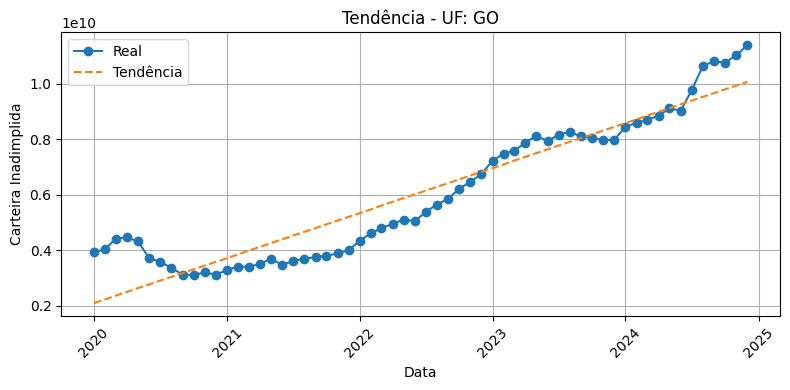

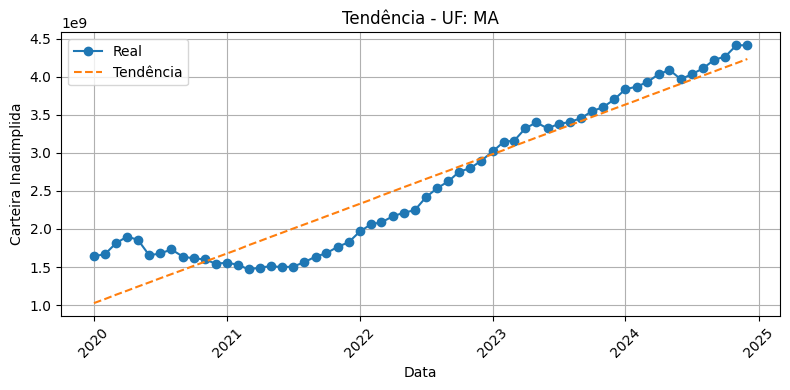

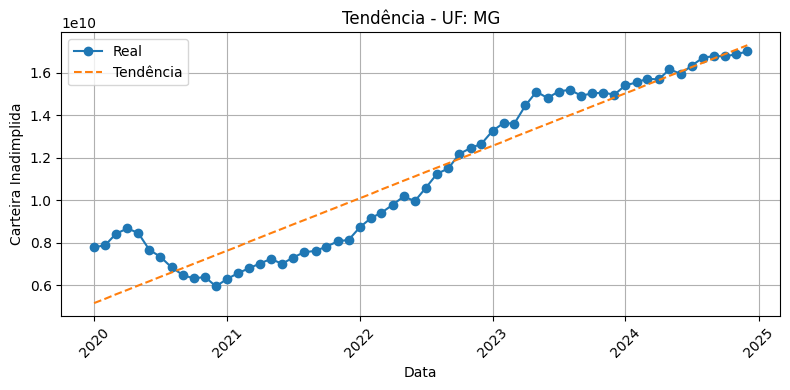

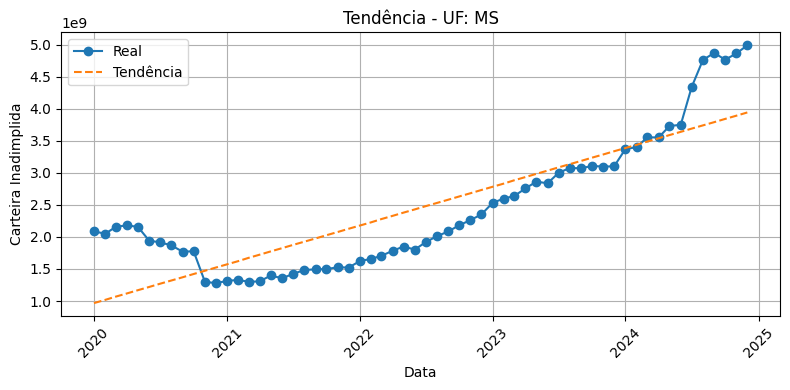

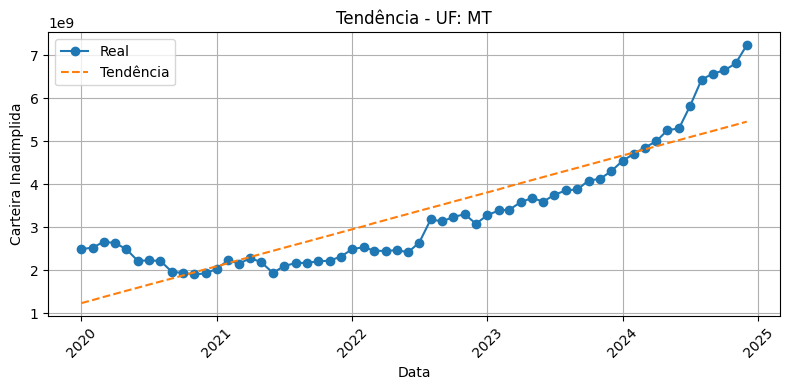

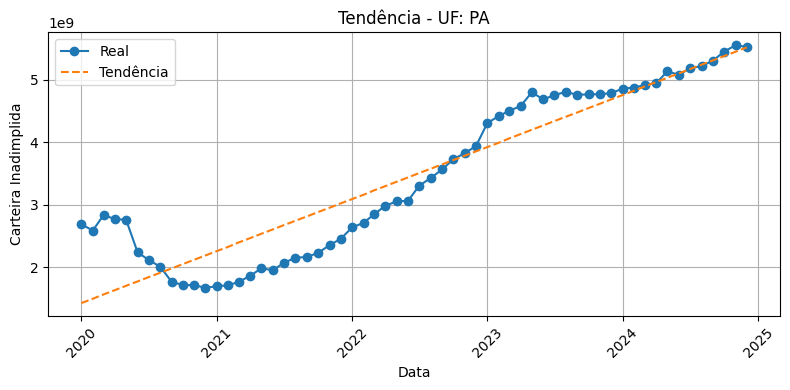

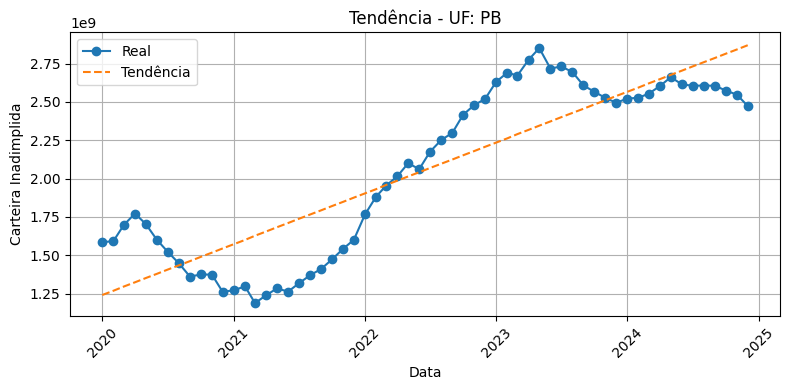

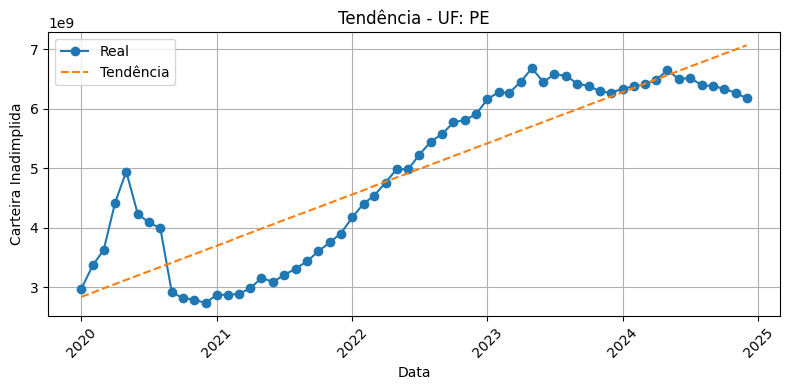

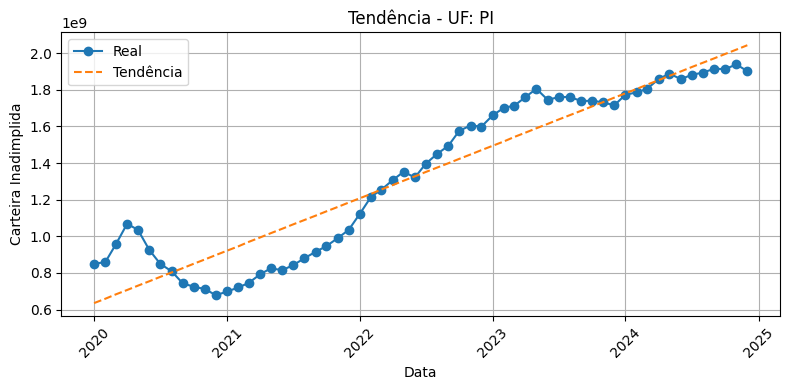

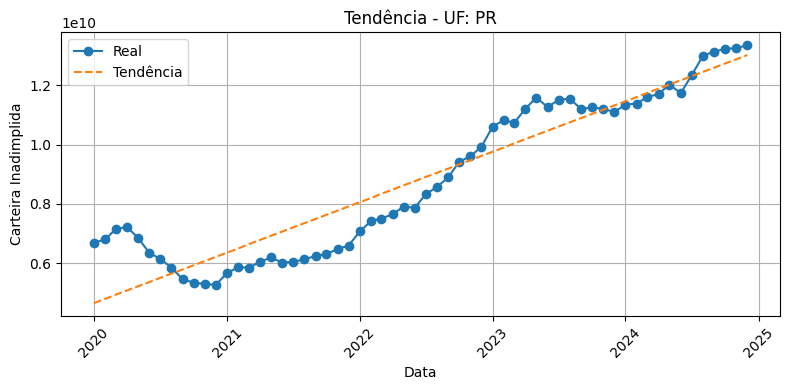

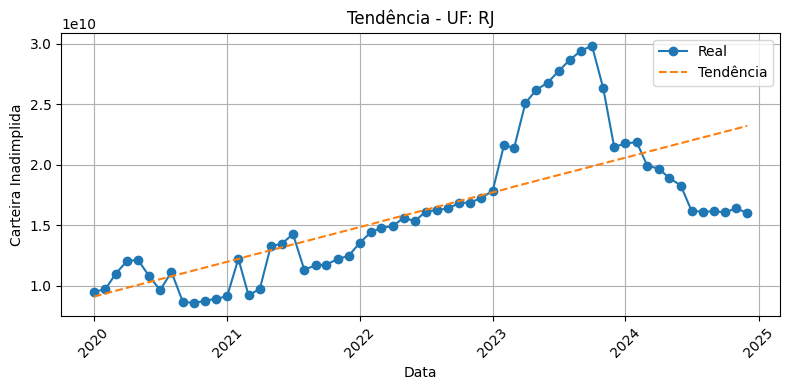

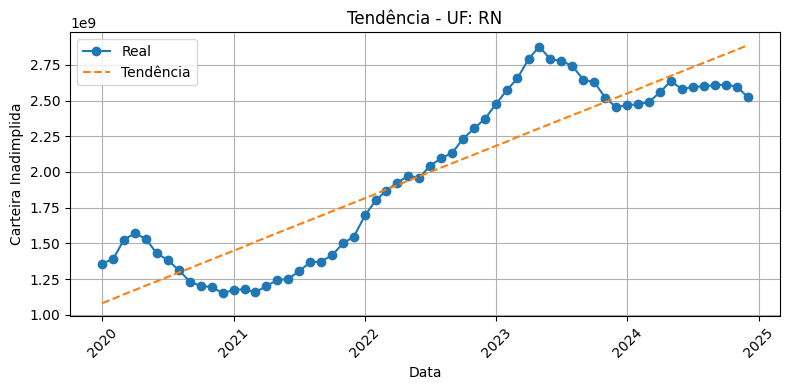

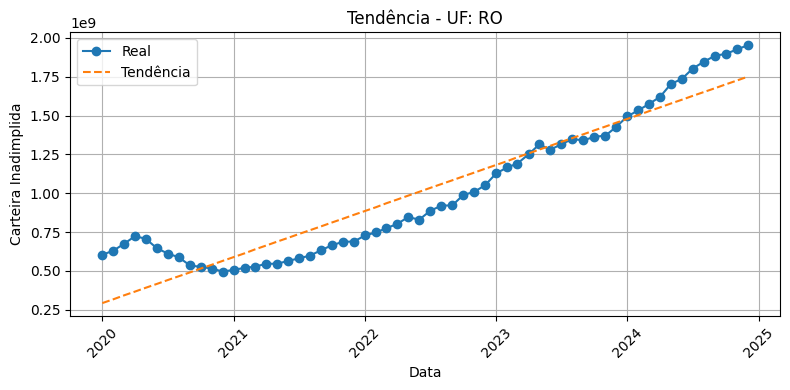

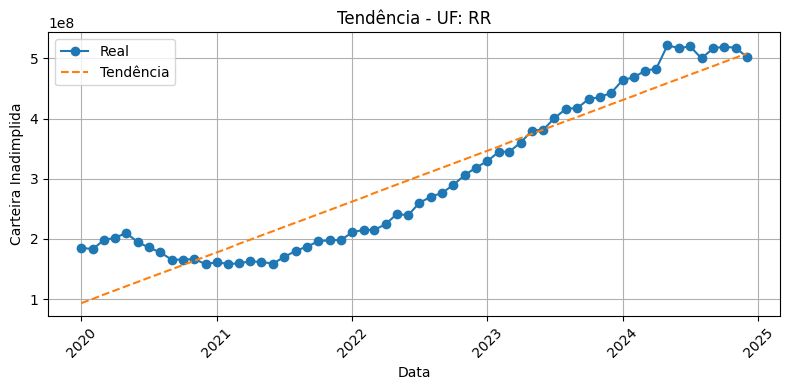

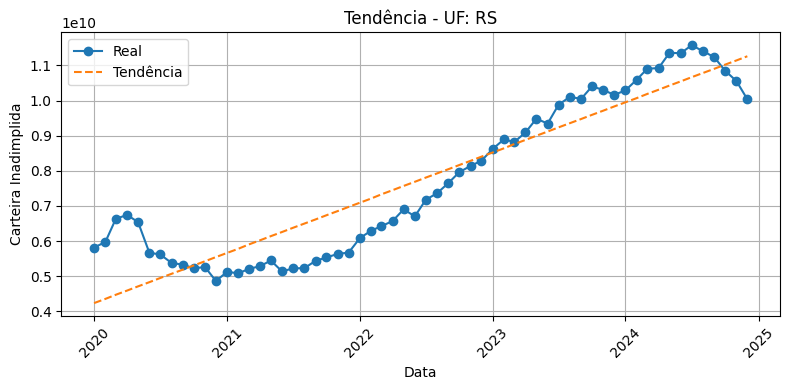

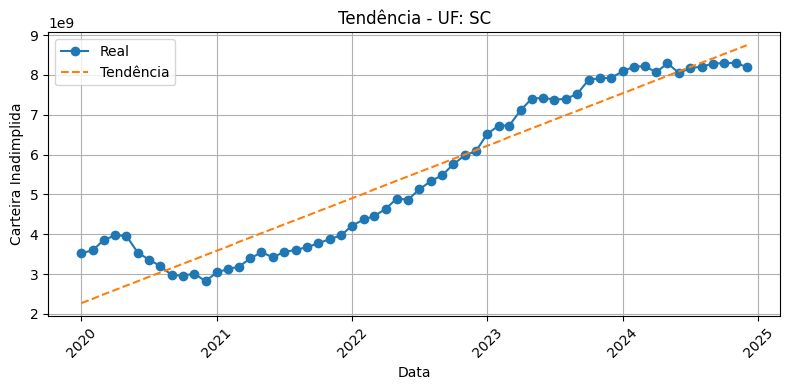

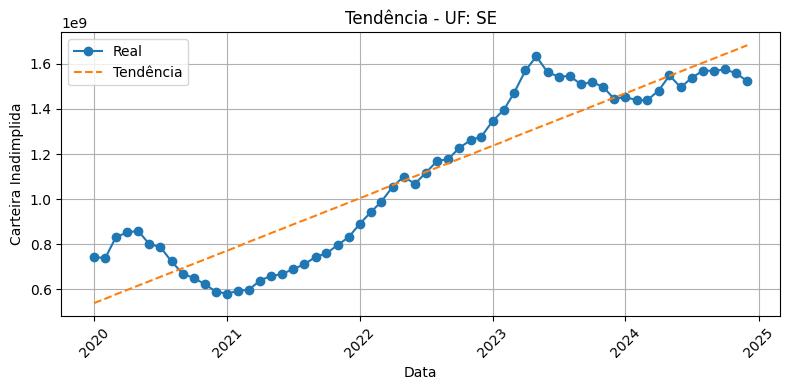

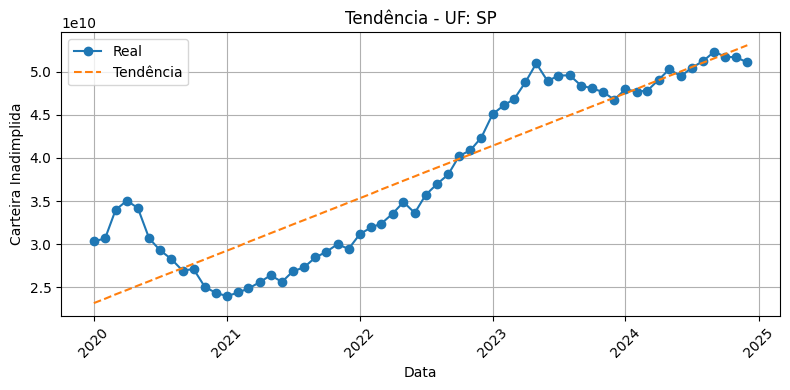

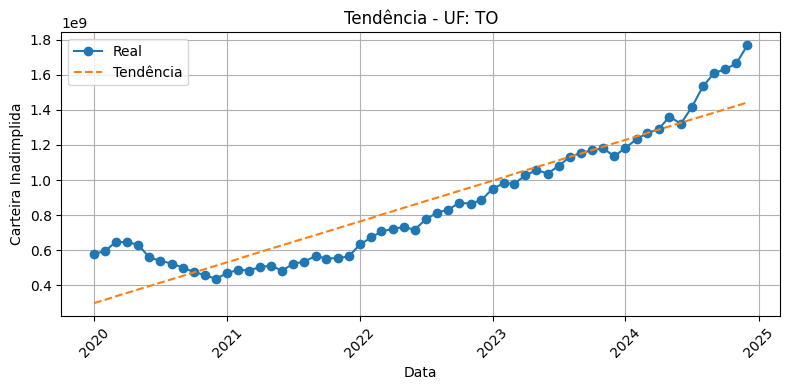

    uf   coeficiente    intercepto        r2
23  SC  1.096741e+08  2.272877e+09  0.904559
9   MA  5.434094e+07  1.026169e+09  0.902021
10  MG  2.057637e+08  5.164503e+09  0.894656
0   AC  7.923884e+06  1.300310e+08  0.888812
21  RR  7.035699e+06  9.323421e+07  0.885885


In [60]:
# Garantindo data no formato correto
df['data_base'] = pd.to_datetime(df['data_base'])
df['ano_mes'] = df['data_base'].dt.to_period('M').dt.to_timestamp()

# Agregar por UF e mês
df_uf = df.groupby(['uf', 'ano_mes'])['soma_carteira_inadimplida_arrastada'].sum().reset_index()

# Lista para guardar os resultados
resultados = []

# Loop por UF
for uf in df_uf['uf'].unique():
    df_temp = df_uf[df_uf['uf'] == uf].copy().sort_values('ano_mes')
    df_temp['mes_num'] = np.arange(len(df_temp))
    
    X = df_temp[['mes_num']]
    y = df_temp['soma_carteira_inadimplida_arrastada']
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    
    y_pred = modelo.predict(X)
    r2 = r2_score(y, y_pred)
    
    resultados.append({
        'uf': uf,
        'coeficiente': modelo.coef_[0],
        'intercepto': modelo.intercept_,
        'r2': r2
    })
    
    # (Opcional) Exibir gráfico para cada UF
    plt.figure(figsize=(8,4))
    plt.plot(df_temp['ano_mes'], y, marker='o', label='Real')
    plt.plot(df_temp['ano_mes'], y_pred, linestyle='--', label='Tendência')
    plt.title(f'Tendência - UF: {uf}')
    plt.xlabel('Data')
    plt.ylabel('Carteira Inadimplida')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# DataFrame com coeficientes de regressão
df_resultados_uf = pd.DataFrame(resultados)
df_resultados_uf.sort_values(by='r2', ascending=False, inplace=True)
print(df_resultados_uf.head())


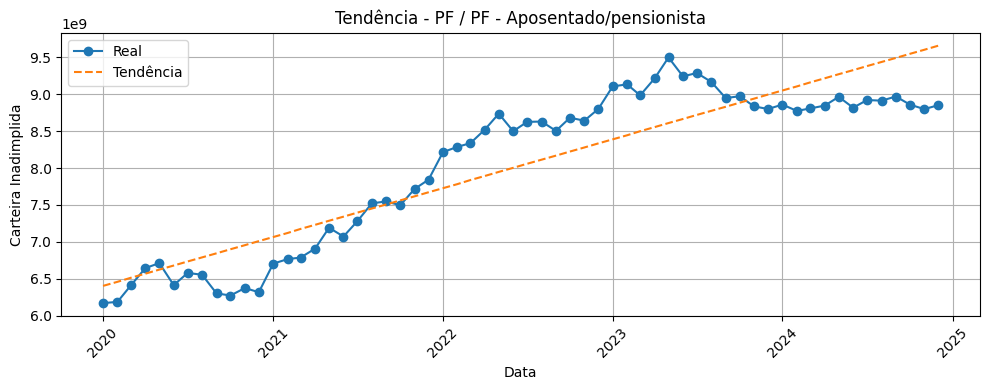

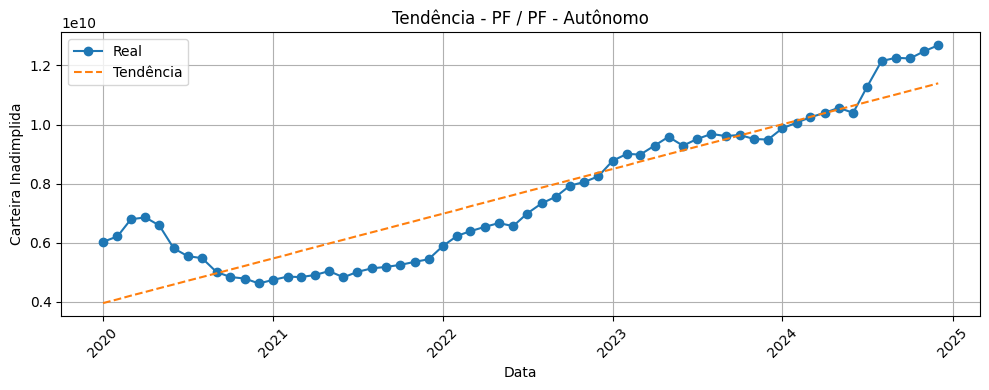

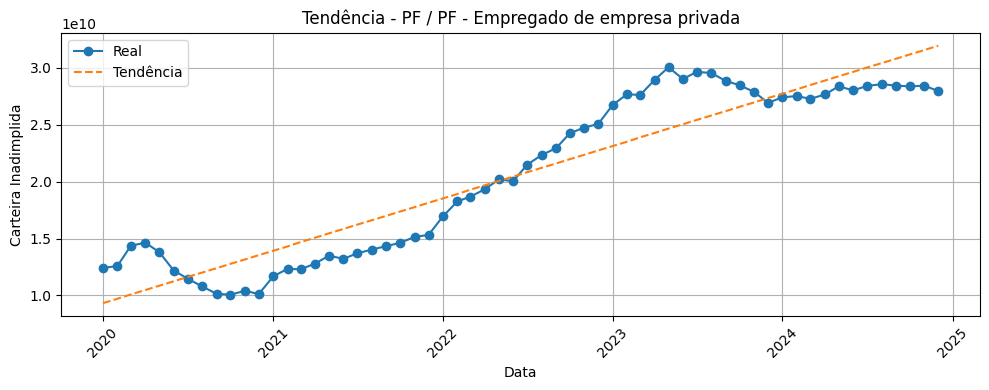

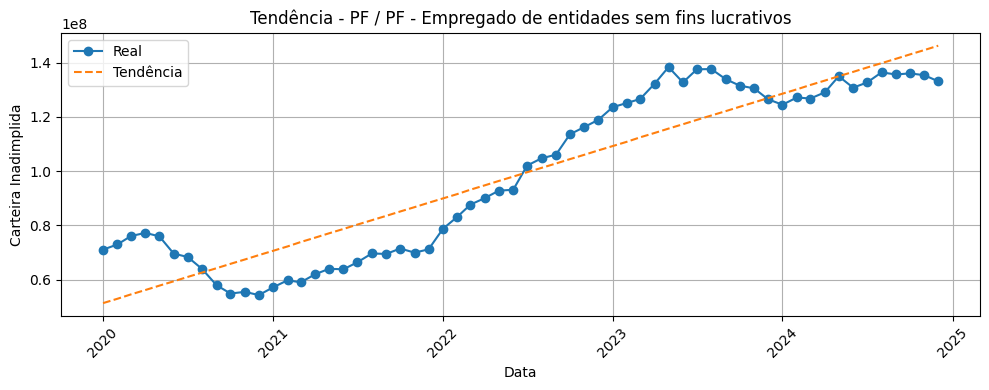

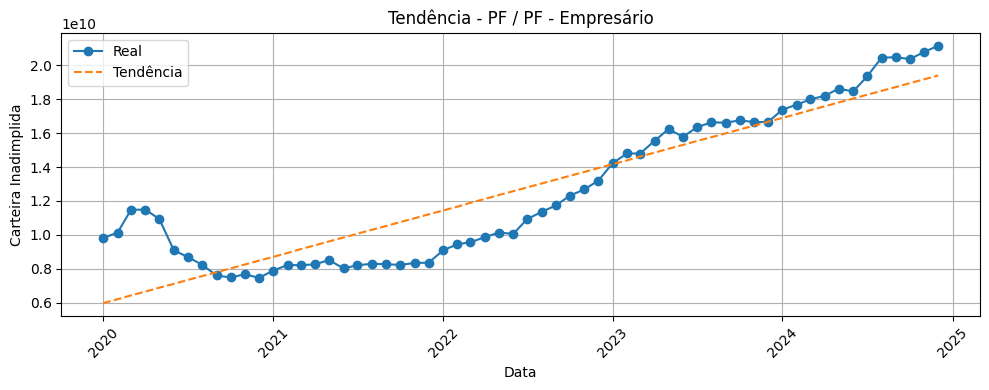

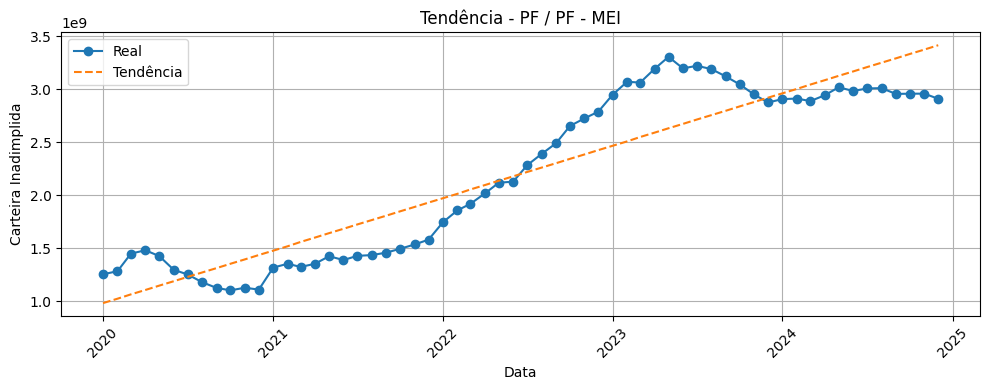

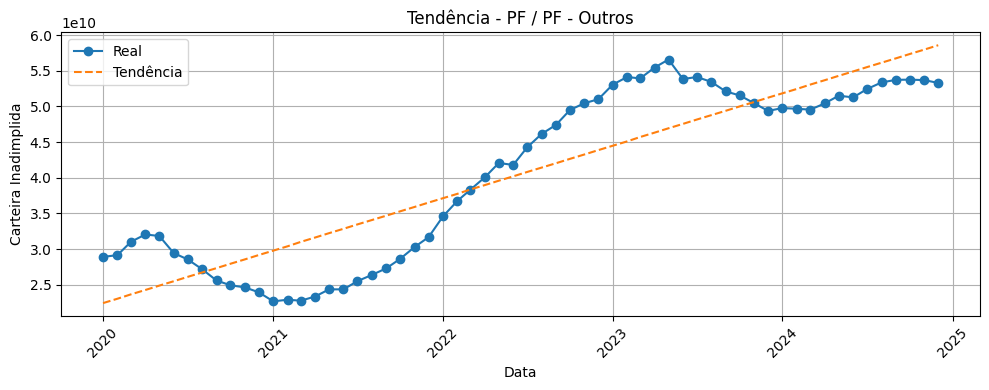

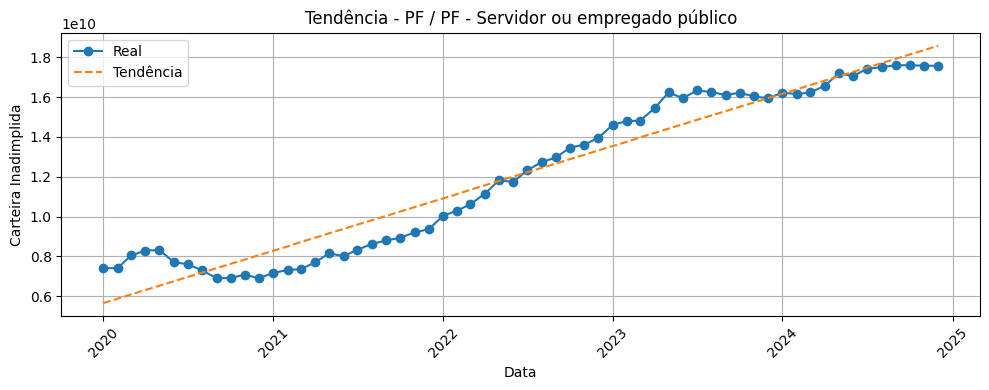

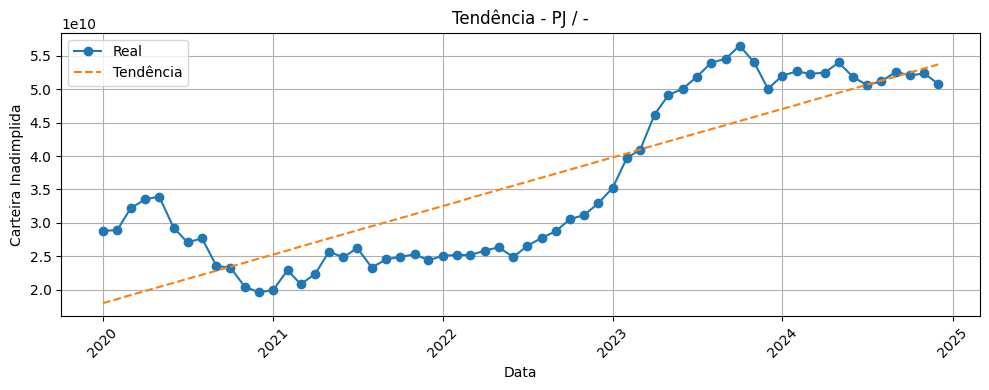

  tipo_cliente                                         ocupacao   coeficiente  \
7           PF               PF - Servidor ou empregado público  2.188904e+08   
2           PF                PF - Empregado de empresa privada  3.830806e+08   
5           PF                                         PF - MEI  4.129214e+07   
3           PF  PF - Empregado de entidades sem fins lucrativos  1.607045e+06   
1           PF                                    PF - Autônomo  1.261225e+08   

     intercepto        r2  
7  5.661147e+09  0.935945  
2  9.331137e+09  0.868951  
5  9.808994e+08  0.843259  
3  5.139141e+07  0.840837  
1  3.955043e+09  0.825129  


In [61]:
# Extrair o tipo de cliente (PF ou PJ) da coluna 'porte'
df['tipo_cliente'] = df['porte'].str.slice(0, 2).str.upper()

# Converter datas e criar variável de tempo
df['data_base'] = pd.to_datetime(df['data_base'])
df['ano_mes'] = df['data_base'].dt.to_period('M').dt.to_timestamp()

# Agregar por tipo_cliente, ocupação e mês
df_grupo = df.groupby(['tipo_cliente', 'ocupacao', 'ano_mes'])['soma_carteira_inadimplida_arrastada'].sum().reset_index()

# Lista de resultados
resultados_ocup = []

# Loop por cada combinação de PF/PJ + Ocupação
grupos = df_grupo.groupby(['tipo_cliente', 'ocupacao'])

for (tipo, ocup), grupo in grupos:
    grupo = grupo.sort_values('ano_mes').copy()
    grupo['mes_num'] = np.arange(len(grupo))
    
    X = grupo[['mes_num']]
    y = grupo['soma_carteira_inadimplida_arrastada']
    
    modelo = LinearRegression()
    modelo.fit(X, y)
    y_pred = modelo.predict(X)
    r2 = r2_score(y, y_pred)
    
    resultados_ocup.append({
        'tipo_cliente': tipo,
        'ocupacao': ocup,
        'coeficiente': modelo.coef_[0],
        'intercepto': modelo.intercept_,
        'r2': r2
    })

    # (Opcional) Gráfico para as 5 maiores tendências
    if abs(modelo.coef_[0]) > 100000:  # ajuste o valor conforme sua escala
        plt.figure(figsize=(10,4))
        plt.plot(grupo['ano_mes'], y, marker='o', label='Real')
        plt.plot(grupo['ano_mes'], y_pred, linestyle='--', label='Tendência')
        plt.title(f'Tendência - {tipo} / {ocup}')
        plt.xlabel('Data')
        plt.ylabel('Carteira Inadimplida')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# DataFrame com resultados
df_resultados_ocup = pd.DataFrame(resultados_ocup)
df_resultados_ocup = df_resultados_ocup.sort_values(by='r2', ascending=False)
print(df_resultados_ocup.head())


14:15:45 - cmdstanpy - INFO - Chain [1] start processing
14:15:47 - cmdstanpy - INFO - Chain [1] done processing


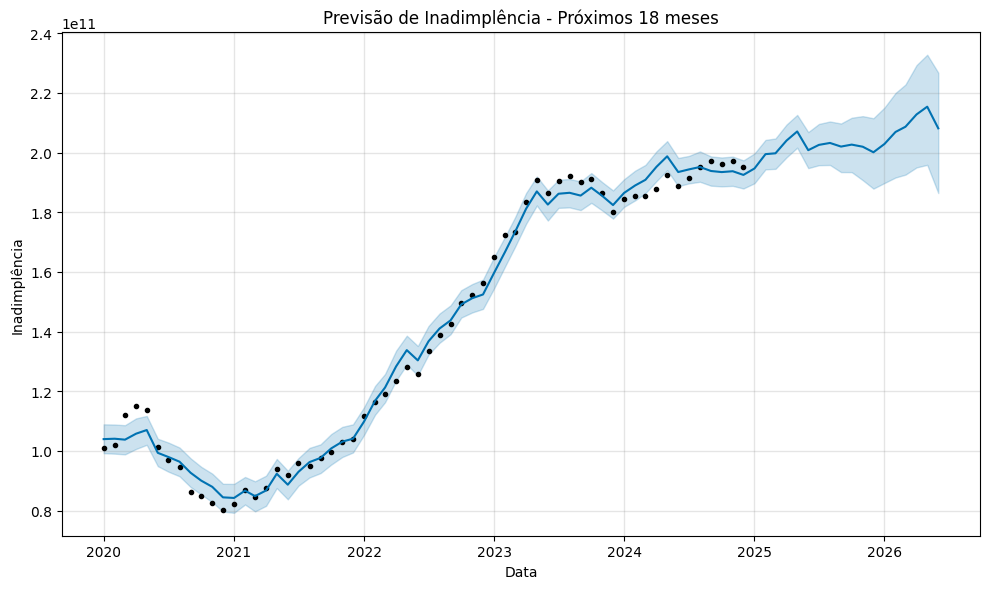

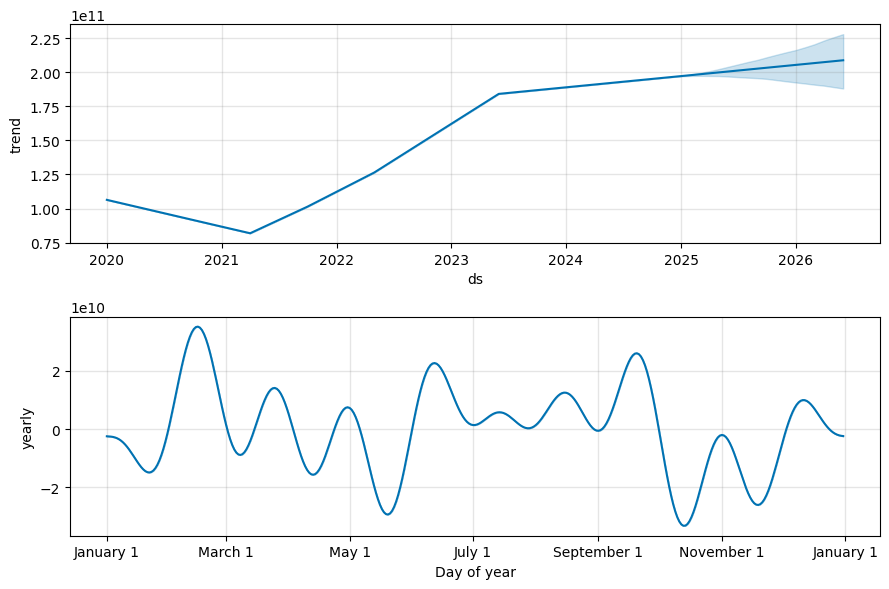

In [67]:
# 2. Preparação dos dados
df['data_base'] = pd.to_datetime(df['data_base'])
df['ano_mes'] = df['data_base'].dt.to_period('M').dt.to_timestamp()

# Agregar inadimplência mensal
df_mensal = df.groupby('ano_mes')['soma_carteira_inadimplida_arrastada'].sum().reset_index()

# Renomear colunas conforme exigido pelo Prophet
df_prophet = df_mensal.rename(columns={
    'ano_mes': 'ds',
    'soma_carteira_inadimplida_arrastada': 'y'
})

# 3. Criar e treinar modelo Prophet
modelo = Prophet()
modelo.fit(df_prophet)

# 4. Criar DataFrame futuro para 18 meses
future = modelo.make_future_dataframe(periods=18, freq='MS')

# 5. Gerar previsões
forecast = modelo.predict(future)

# 6. Visualizar previsão
fig1 = modelo.plot(forecast)
plt.title('Previsão de Inadimplência - Próximos 18 meses')
plt.xlabel('Data')
plt.ylabel('Inadimplência')
plt.tight_layout()
plt.show()

# 7. Visualizar componentes (tendência, sazonalidade)
fig2 = modelo.plot_components(forecast)
plt.tight_layout()
plt.show()

In [68]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


# Preparar colunas de data e tipo de cliente (PF/PJ)
df['data_base'] = pd.to_datetime(df['data_base'])
df['ano_mes'] = df['data_base'].dt.to_period('M').dt.to_timestamp()
df['tipo_cliente'] = df['cliente'].str.extract(r'(\bPF\b|\bPJ\b)', expand=False)

# Lista para guardar resultados de cada grupo
resultados = []

# Agrupar por UF, Ocupação e Tipo de Cliente
grupos = df.groupby(['uf', 'ocupacao', 'tipo_cliente'])

# Loop por grupo com barra de progresso
for (uf, ocupacao, tipo), grupo in tqdm(grupos, desc="Processando grupos"):

    # Agregar inadimplência por mês
    df_mensal = grupo.groupby('ano_mes')['soma_carteira_inadimplida_arrastada'].sum().reset_index()
    if len(df_mensal) < 6:
        continue  # pula grupos com poucos dados

    df_mensal = df_mensal.sort_values('ano_mes').copy()
    df_mensal['mes_num'] = np.arange(len(df_mensal))

    # Treinar regressão linear
    X = df_mensal[['mes_num']]
    y = df_mensal['soma_carteira_inadimplida_arrastada']
    modelo = LinearRegression()
    modelo.fit(X, y)

    # Gerar previsão para 18 meses
    meses_futuros = pd.date_range(start=df_mensal['ano_mes'].iloc[-1] + pd.offsets.MonthBegin(1),
                                   periods=18, freq='MS')
    mes_num_futuro = np.arange(len(df_mensal), len(df_mensal) + 18).reshape(-1, 1)
    y_futuro = modelo.predict(mes_num_futuro)

    # Histórico
    df_hist = df_mensal[['ano_mes', 'soma_carteira_inadimplida_arrastada']].copy()
    df_hist['tipo'] = 'histórico'
    df_hist['uf'] = uf
    df_hist['ocupacao'] = ocupacao
    df_hist['tipo_cliente'] = tipo

    # Previsão
    df_prev = pd.DataFrame({
        'ano_mes': meses_futuros,
        'soma_carteira_inadimplida_arrastada': y_futuro,
        'tipo': 'previsão',
        'uf': uf,
        'ocupacao': ocupacao,
        'tipo_cliente': tipo
    })

    # Combinar e guardar
    df_total = pd.concat([df_hist, df_prev], ignore_index=True)
    resultados.append(df_total)

# Unir todos os resultados e salvar CSV
df_final = pd.concat(resultados, ignore_index=True)
df_final.to_csv('previsao_inadimplencia_por_grupo.csv', index=False, encoding='utf-8-sig')

print("✅ Previsões salvas em previsao_inadimplencia_por_grupo.csv")

Processando grupos:   0%|                                                                             | 0/243 [00:00<?, ?it/s]C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
Processando grupos:   0%|▎                                                                    | 1/243 [00:02<09:22,  2.32s/it]C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\AU355EE\AppData\Local\Programs\Python\Python313\Lib\site-p

✅ Previsões salvas em previsao_inadimplencia_por_grupo.csv
